<a href="https://colab.research.google.com/github/R-Ramana/EE4211-Project/blob/main/Question%203/EE4211_Group_9_Question_3_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Proposal 

**We propose a multi-pronged approach wherein we will be tackling the given problem from the perspective of 2 different stakeholders: vehicle drivers and the Urban Redevelopment Authority (URA)/Land Transport Authority (LTA). Our approach allows us to analyse data in the short term as well as the long term.**

## Short-term analytics

Our recommendation system targets users aiming to plan their trips early. Such users will be required to provide their destination and estimated time of arrival (in terms of hours from now capped at 24 hours) and our system will provide them with the best available parking option based on distance from their destination and parking availability.

### ML Forecasting for carpark availability
 - Dynamic ML system that uses the following data depending on the month to predict hourly availability[1]:

     - Past 2 (exclude 2020 due to covid) years (October 2019, October 2021) for the same month (in our case, October)
     - Past 2 months (August and September 2022)
     - October 2022 data for testing purposes.
     
**[1] For the purpose of this project we will be predicting October 2022's data to allow us to test the usability/performance of the system.**

### Algorithm
        
1. Filter out a list of open carparks based on arrival hour. 
2. Calculate distance based on destination geo coordinates and coordinates of open carparks
3. Partial Selection Sort according to distance (least to max) to store possible open carparks within a 1km distance for that sample.
3. Predict carpark availability for the top chosen carparks with the given arrival hour using the ML model described above.
4. Choose the top <=5 most available carparks with least distance:
    - if carparks with availability >=50% exist, sort them by distance 
    - else, sort by availability and choose the top 5 most available carkparks   
5. Display the recommended carpark list with availability and distance to the user.
     



<table>
  <tr>
    <th style="text-align:center;">Data Attribute</th>
    <th style="text-align:center;">Source</th>
    <th style="text-align:center;">Remarks</th>
  </tr>
  <tr>
    <td style="text-align:left;">Geo-coordinates of current/final destination</td>
    <td style="text-align:left;">User Input</td>
    <td style="text-align:left;">To provide best carpark recommendations based on estimated time of arrrival and carparks near destination</td>
  </tr>
  <tr>
    <td style="text-align:left;">Geo-coordinates of carparks</td>
    <td style="text-align:left;" rowspan="3"><a href"https://data.gov.sg/dataset/hdb-carpark-information">Carpark Info Dataset</a></td>
    <td style="text-align:left;">To recommend carparks based on distance from destination</td>
  </tr>
  <tr>
      <td style="text-align:left;">Cost of parking</td>
      <td style="text-align:left;">To recommend carparks based on cost</td>
      
  </tr>
  <tr>
      <td style="text-align:left;">Carpark opening hours</td>
      <td style="text-align:left;">To recommend carparks that are open during user's time of arrival</td>
      
  </tr>
  <tr>
      <td style="text-align:left;">Carpark availability</td>
      <td style="text-align:left;"><a href"https://data.gov.sg/dataset/carpark-availability">Carpark Availability Dataset</a></td>
      <td style="text-align:left;">To recommend carparks based on availability</td>
  <tr>
      <td colspan="3" style="text-align:center; font-size:12px; text-transform:uppercase;"><b>If time permits...</b></td>
      
      
  </tr>
  <tr>
      <td style="text-align:left;">Weather forecast</td>
      <td style="text-align:left;"><a href"https://www.programmableweb.com/api/nea-datasets">NEA Weather API</a></td>
      <td style="text-align:left;">To recommend carparks based on current weather conditions</td>
      
  </tr>
  <tr>
      <td style="text-align:left;">Traffic Conditions</td>
      <td style="text-align:left;"><a href"https://datamall.lta.gov.sg/content/datamall/en/dynamic-data.html">Estimated Travel Times API</td>
      <td style="text-align:left;">To improve our time-of-arrival estimation</td>
      
  </tr>

</table>


**If time permits, we intend on supplementing our current data sources with Real-time Traffic Data and Weather forecasting insights to improve our reccomendations.**

### Long-term analytics

#### From a urban developer/Singapore Land Transport Authority's point of view:

We believe long-term analysis of this data will be beneficial from an urban developer's perspective, specifically for the LTA and URA. By looking at the usage of carparks trends through historical data analysis, we can forecast the availability of carparks in the long-term. Developers can identify hotspots where there may often be high usage of car parks and thus an excellent location to build more lots or carparks to cater to the high demand. In contrast, this long-term analysis can also identify potential spots where space can be saved by reducing the number of lots or carparks that don't have high usage forecasted.

**If time permits, with the additional data on upcoming HDB developments, we can take in the geo-coordinates of existing carparks as well as carpark availability, to predict if more carparks need to be built around these upcoming HDB developments.**


### PROPOSAL FEEDBACK:


*   Very extensive range of dataset and data sources

#### Recommendations:
*   Long-term analytics can clearly use a machine learning model, whereas for the short-term
analytics, the “features” are clear, but the “labels” are not so clear. If the “labels” are made
clear in the final report, this would be an excellent problem and solution.
*   There is a higher potential for the short-term analytics proposal, but it is tougher as well. We
recommend that this group approaches us during the live consultation sessions if you want
to verify with us and provide us with more details so that we can help. Else, if the group
already has clearly defined “labels” in mind, then please execute it. 

*Q3.1 At this point, you understand the data quite well. Carry out the analysis you proposed
in your group project proposal. You should use the dataset given but you may also use
additional datasets to supplement your analysis, look at unaggregated data, etc. Please
be sure to justify why the analysis is useful and interesting in the context of a data science
project. Note that you are not limited to the initial proposal and are free to expand on it.*

## Recommendation App

In [7]:
import pandas as pd
import numpy as np
# import geopandas
import geopy
import geopy.distance
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

In [16]:
def pred_func(current_time, arrival_hour_in, csv, carpark_array):
    df = pd.read_csv(csv)
    
    current_day = int(current_time.day)
    current_hour = int(current_time.hour)
    arrival_hour = current_hour + arrival_hour_in
    
    if arrival_hour > 24:
        arrival_hour -= 24
        current_day += 1
    
    predictions = []
    actual = []
    actual_avail = pd.DataFrame()
    
    print("current day", current_day)
    print("arrival hour", arrival_hour)
    
    for carpark in carpark_array:
        carpark_df = df[df["carpark_number"] == carpark]
        day_df = carpark_df[carpark_df["day"] == current_day]
        final_df = day_df[day_df["hour"] == arrival_hour]
        
        filename = "models/model_" + carpark + ".sav"
        model = pickle.load(open(filename, 'rb'))
        
        prediction = model.predict([[current_day, arrival_hour, final_df['lag_1'].iloc[0], final_df['lag_168'].iloc[0]]])
        actual.append(final_df['percent_lots_available'].values[0])
        prediction = prediction[0] if prediction > 0 else 0.0
        predictions.append(prediction)
        
    actual_avail['carpark_number'] = carpark_array
    actual_avail['avail'] = actual
    print("\nactual availabilities")
    print(actual_avail.sort_values(by=['avail'], ascending=False))
        
    return predictions

In [17]:
def get_user_input():
    pd.set_option('display.max_rows', 100)
    user_pref = []
    
    df = pd.read_csv('landmark_locations.csv', index_col=False)
    
    print(df[['Landmark', 'Postal_Code']])
    print("\n")
    print("Enter the index of your preferred Landmark: ")
    
    user_loc = input()
    user_loc_int = int(user_loc)
    
    landmark = df.iloc[user_loc_int]['Landmark']
    postal_code = df.iloc[user_loc_int]['Postal_Code']
    
    user_pref.append(postal_code)
    
    output = "You have selected the following landmark: " + landmark + ", " + str(postal_code)
    
    print("\n")
    print(output)
    print("\n")
    print("How many hours from now will you reach your destination? (capped at 24)")
    hour = input()
    
    user_pref.append(int(hour))
    
    return user_pref

In [18]:
def get_recommendation(postal_code, hour):

    carparks_info = pd.read_csv("carparks_info_cbd_area.csv")

    now = datetime.now()
    arrival_hour = (now.hour + int(hour)) % 24
    arrival_minute = now.minute
    
    open = ['7AM-10.30PM', '7AM-7PM', 'NO', 'WHOLE DAY']

    if(arrival_hour < 7):
        open = ['WHOLE DAY']
    elif(arrival_hour > 22 or (arrival_hour == 22 and arrival_minute > 15)):
        open = ['WHOLE DAY']
    elif(arrival_hour > 19):
        open = ['WHOLE DAY', '7AM-10.30PM']
    else: 
        open = ['WHOLE DAY', '7AM-10.30PM', '7AM-7PM']
    
    carparks_info = carparks_info[carparks_info['short_term_parking'].isin(open)]
    
    locator = geopy.Nominatim(user_agent='myGeocoder')
    location = locator.geocode("Singapore, Singapore, " + str(postal_code))
    coords_1 = (location.latitude, location.longitude)
    print("destination coordinates: ", coords_1)
    
    carpark_dist = pd.DataFrame()
    carpark_number = []
    distance = []

    for i in range(0, len(carparks_info)):
        carpark_lat = carparks_info.iloc[i]["lat"]
        carpark_lon = carparks_info.iloc[i]["lon"]
        coords_2 = (carpark_lat, carpark_lon)
        ## todo calc distance for each carpark and store in carparks_info under distance column
        dist = geopy.distance.geodesic(coords_1, coords_2).km
        carparknumber = carparks_info["car_park_no"].iloc[i]
        carpark_number.append(carparknumber)
        distance.append(dist)

#     coords_2 = (1.301836879239155, 103.85288429942284)
#     dist = geopy.distance.geodesic(coords_1, coords_2).km
    carpark_dist["carpark_number"] = carpark_number
    carpark_dist["carpark_distance"] = distance
    carpark_dist["carpark_distance"] = carpark_dist["carpark_distance"]   
    carpark_dist = carpark_dist.sort_values(by=['carpark_distance'])
    closest_carparks = carpark_dist.head(10)
    
    predictions = pred_func(now, hour, "oct_data_with_lags.csv", np.asarray(closest_carparks['carpark_number']))
    closest_carparks['percent_lots_available'] = predictions
    
    closest_carparks_sorted = closest_carparks.sort_values(by=['percent_lots_available'], ascending=False)
    print("\n\nRecommended Carparks")
    print(closest_carparks_sorted)
    
    # near_carparks = pd.DataFrame()
    # near_carparks_no = []
    # near_carparks_dist = []
    # for i in range(0, len(carpark_dist)):
    #   carpark_no = carpark_dist.iloc[i]["carpark_number"]
    #   dist_near = carpark_dist.iloc[i]["carpark_distance"]
    #   if dist_near < 6:
    #     near_carparks_no.append(carpark_no)
    #     near_carparks_dist.append(dist_near)
    #   else:
    #     i = i+1
    # near_carparks["carpark_number"] = near_carparks_no
    # near_carparks["carpark_distance"] = near_carparks_dist

In [20]:
user_inp = get_user_input()
get_recommendation(user_inp[0], user_inp[1])

                                       Landmark  Postal_Code
0         Buddha Tooth Relic Temple and Museum.        58840
1                         Sri Mariamman Temple.        58793
2                           Maxwell Food Centre        69184
3                       Thian Hock Keng Temple.        68613
4                    Chinatown Heritage Centre.        59207
5                       Chinatown Street Market        58943
6                  Singapore Musical Box Museum        68619
7                             Chinatown Complex        50335
8                                 Masjid Jamae.        58767
9                         People's Park Complex        59108
10                              Masjid Al-Abrar        68635
11                       100 AM Shopping centre        79027
12                 Icon Village Shopping Centre        78877
13                   Bangladesh High Commission        89058
14                 Tanjong Pagar Community Club        89774
15                      

## Removing carparks with bad sensor data

In [30]:
# carparks_info = pd.read_csv("carparks_info_cbd_area.csv")
# carparks_keep = pd.read_csv("Carparks_Keep_List.csv")
# groups = carparks_keep.groupby(['Carpark'])
# carparks_groups = [key for key, _ in groups]
# carparks_info_keep = carparks_info[carparks_info['car_park_no'].isin(carparks_groups)]
# carparks_info_keep

car_park_no                                 address     x_coord  \
0          AR5M                  BLK 19A DOVER CRESCENT  22562.8641   
1          AR7M                BLK 12A DOVER CLOSE EAST  22643.9533   
2           AV1  BLK 120/120A/121-127 ALEXANDRA VILLAGE  24649.7520   
3          BMVM               BLK 126A BUKIT MERAH VIEW  26866.0055   
4           BM1                BLK 28 JALAN BUKIT MERAH  25357.1463   
..          ...                                     ...         ...   
163        TE14           BLK 140/142 JALAN BUKIT MERAH  27503.2019   
164        TE25    BLK 17/31/141/150 KAMPONG BAHRU ROAD  27718.3359   
166         TE4           BLK 132-138 JALAN BUKIT MERAH  27390.6755   
167         TPM              BLK 1/6 TANJONG PAGAR MSCP  28999.2720   
168         YHS         BLK 11/12/13 YORK HILL CAR PARK  28508.3965   

        y_coord          car_park_type type_of_parking_system  \
0    32184.9758  MULTI-STOREY CAR PARK     ELECTRONIC PARKING   
1    31900.5591  MULTI-STOREY CAR PARK     ELECTRONIC PARKING   
2    29778.7266       SURFACE CAR PARK     ELECTRONIC PARKING   
3    29672.9702  MULTI-STOREY CAR PARK     ELECTRONIC PARKING   
4    29858.3486       SURFACE CAR PARK     ELECTRONIC PARKING   
..          ...                    ...                    ...   
163  28827.5456       SURFACE CAR PARK     ELECTRONIC PARKING   
164  28870.7891       SURFACE CAR PARK     ELECTRONIC PARKING   
166  28981.1406       SURFACE CAR PARK     ELECTRONIC PARKING   
167  28661.7751  MULTI-STOREY CAR PARK     ELECTRONIC PARKING   
168  29880.2227       SURFACE CAR PARK     ELECTRONIC PARKING   

    short_term_parking             free_parking night_parking  car_park_decks  \
0            WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES              12   
1            WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES               7   
2            WHOLE DAY                       NO           YES               0   
3            WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES              11   
4            WHOLE DAY                       NO           YES               0   
..                 ...                      ...           ...             ...   
163        7AM-10.30PM  SUN & PH FR 7AM-10.30PM            NO               0   
164        7AM-10.30PM  SUN & PH FR 7AM-10.30PM            NO               0   
166        7AM-10.30PM  SUN & PH FR 7AM-10.30PM            NO               0   
167          WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES               7   
168          WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES               0   

     gantry_height car_park_basement       lat         lon  
0             2.15                 N  1.307344  103.784463  
1             2.15                 N  1.304771  103.785192  
2             4.50                 N  1.285583  103.803215  
3             1.90                 N  1.284626  103.823129  
4             0.00                 N  1.286303  103.809571  
..             ...               ...       ...         ...  
163           4.50                 N  1.276981  103.828855  
164           4.50                 N  1.277372  103.830788  
166           0.00                 N  1.278370  103.827844  
167           1.80                 N  1.275481  103.842297  
168           0.00                 N  1.286501  103.837887  

[146 rows x 14 columns]

In [31]:
# carparks_info_keep.to_csv("carparks_info_cbd_area.csv", index=False)

## Cleaning up Carpark Info Dataset

In [ ]:
carpark_info = pd.read_csv("hdb-carpark-information.csv")
carpark_info

car_park_no                                      address     x_coord  \
0            ACB  BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK  30314.7936   
1            ACM                    BLK 98A ALJUNIED CRESCENT  33758.4143   
2            AH1                          BLK 101 JALAN DUSUN  29257.7203   
3           AK19               BLOCK 253 ANG MO KIO STREET 21  28185.4359   
4           AK31                 BLK 302/348 ANG MO KIO ST 31  29482.0290   
...          ...                                          ...         ...   
2177        Y77M                      BLK 461 YISHUN AVENUE 6  29850.1522   
2178        Y78M                         BLK 468 YISHUN ST 43  30057.2209   
2179          Y8     BLK 731/746 YISHUN STREET 71,72/AVENUE 5  27772.9219   
2180        Y82M                         BLK 478 YISHUN ST 42  29935.5818   
2181          Y9                 BLK 747/752 YISHUN STREET 72  28077.2305   

         y_coord          car_park_type type_of_parking_system  \
0     31490.4942      BASEMENT CAR PARK     ELECTRONIC PARKING   
1     33695.5198  MULTI-STOREY CAR PARK     ELECTRONIC PARKING   
2     34500.3599       SURFACE CAR PARK     ELECTRONIC PARKING   
3     39012.6664       SURFACE CAR PARK         COUPON PARKING   
4     38684.1754       SURFACE CAR PARK         COUPON PARKING   
...          ...                    ...                    ...   
2177  45576.0125  MULTI-STOREY CAR PARK     ELECTRONIC PARKING   
2178  45166.4820  MULTI-STOREY CAR PARK     ELECTRONIC PARKING   
2179  45686.2734       SURFACE CAR PARK     ELECTRONIC PARKING   
2180  45679.7181  MULTI-STOREY CAR PARK     ELECTRONIC PARKING   
2181  45507.8047       SURFACE CAR PARK     ELECTRONIC PARKING   

     short_term_parking             free_parking night_parking  \
0             WHOLE DAY                       NO           YES   
1             WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   
2             WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   
3               7AM-7PM                       NO            NO   
4                    NO                       NO            NO   
...                 ...                      ...           ...   
2177          WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   
2178          WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   
2179          WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   
2180          WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   
2181          WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   

      car_park_decks  gantry_height car_park_basement  
0                  1           1.80                 Y  
1                  5           2.10                 N  
2                  0           0.00                 N  
3                  0           0.00                 N  
4                  0           0.00                 N  
...              ...            ...               ...  
2177              10           2.15                 N  
2178               4           2.15                 N  
2179               0           4.50                 N  
2180              11           2.15                 N  
2181               0           4.50                 N  

[2182 rows x 12 columns]

In [ ]:
## Reference from: https://github.com/zkkmin/coordconvert/blob/master/coordConverter.py

import requests
import csv
from sys import argv
import sys

# If python version is 2.5, install simplejson module and modified the module path in sys.path.apped()
if sys.version_info[:2][1] > 5:
    import json
else:
    sys.path.append("C:\\Python25\\Lib\\site-packages\\simplejson-3.0.7-py2.5.egg")
    import simplejson as json


url = "http://tasks.arcgisonline.com/ArcGIS/rest/services/Geometry/GeometryServer/project?"
inSR = ""
outSR = ""
X = ""
Y = ""
       
inSR = "3414"
outSR = "4326"

lat = []
lon = []

carpark_info['lon'] = 0

for i in range(0, len(carpark_info)):
    X = carpark_info.iloc[i]["x_coord"]
    Y = carpark_info.iloc[i]["y_coord"]

    geometries = 'geometries=%7B"geometryType"%3A"esriGeometryPoint"%2C"geometries"%3A%5B%7B"x"%3A' + str(X) + '%2C"y"%3A' + str(Y) + '%7D%5D%7D&f=pjson'  
    fullurl = url + 'inSR=' + inSR + '&outSR=' +outSR + '&' + geometries

    r = requests.get(fullurl)
    contents = json.loads(r.text)

    latitude = contents['geometries'][0]['y']
    lat.append(latitude)
    longitude = contents['geometries'][0]['x']
    lon.append(longitude)

In [ ]:
carpark_info['lat'] = lat
carpark_info['lon'] = lon

carpark_info

car_park_no                                      address     x_coord  \
0            ACB  BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK  30314.7936   
1            ACM                    BLK 98A ALJUNIED CRESCENT  33758.4143   
2            AH1                          BLK 101 JALAN DUSUN  29257.7203   
3           AK19               BLOCK 253 ANG MO KIO STREET 21  28185.4359   
4           AK31                 BLK 302/348 ANG MO KIO ST 31  29482.0290   
...          ...                                          ...         ...   
2177        Y77M                      BLK 461 YISHUN AVENUE 6  29850.1522   
2178        Y78M                         BLK 468 YISHUN ST 43  30057.2209   
2179          Y8     BLK 731/746 YISHUN STREET 71,72/AVENUE 5  27772.9219   
2180        Y82M                         BLK 478 YISHUN ST 42  29935.5818   
2181          Y9                 BLK 747/752 YISHUN STREET 72  28077.2305   

         y_coord          car_park_type type_of_parking_system  \
0     31490.4942      BASEMENT CAR PARK     ELECTRONIC PARKING   
1     33695.5198  MULTI-STOREY CAR PARK     ELECTRONIC PARKING   
2     34500.3599       SURFACE CAR PARK     ELECTRONIC PARKING   
3     39012.6664       SURFACE CAR PARK         COUPON PARKING   
4     38684.1754       SURFACE CAR PARK         COUPON PARKING   
...          ...                    ...                    ...   
2177  45576.0125  MULTI-STOREY CAR PARK     ELECTRONIC PARKING   
2178  45166.4820  MULTI-STOREY CAR PARK     ELECTRONIC PARKING   
2179  45686.2734       SURFACE CAR PARK     ELECTRONIC PARKING   
2180  45679.7181  MULTI-STOREY CAR PARK     ELECTRONIC PARKING   
2181  45507.8047       SURFACE CAR PARK     ELECTRONIC PARKING   

     short_term_parking             free_parking night_parking  \
0             WHOLE DAY                       NO           YES   
1             WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   
2             WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   
3               7AM-7PM                       NO            NO   
4                    NO                       NO            NO   
...                 ...                      ...           ...   
2177          WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   
2178          WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   
2179          WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   
2180          WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   
2181          WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   

      car_park_decks  gantry_height car_park_basement       lat         lon  
0                  1           1.80                 Y  1.301063  103.854118  
1                  5           2.10                 N  1.321004  103.885061  
2                  0           0.00                 N  1.328283  103.844620  
3                  0           0.00                 N  1.369091  103.834985  
4                  0           0.00                 N  1.366120  103.846636  
...              ...            ...               ...       ...         ...  
2177              10           2.15                 N  1.428448  103.849944  
2178               4           2.15                 N  1.424744  103.851805  
2179               0           4.50                 N  1.429445  103.831278  
2180              11           2.15                 N  1.429386  103.850712  
2181               0           4.50                 N  1.427831  103.834013  

[2182 rows x 14 columns]

In [ ]:
# carpark_info.to_csv('carpark_info_latlon.csv', index=False)

In [ ]:
carpark_info_latlon = pd.read_csv("carpark_info_latlon.csv")
carpark_info_latlon

car_park_no                                      address     x_coord  \
0            ACB  BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK  30314.7936   
1            ACM                    BLK 98A ALJUNIED CRESCENT  33758.4143   
2            AH1                          BLK 101 JALAN DUSUN  29257.7203   
3           AK19               BLOCK 253 ANG MO KIO STREET 21  28185.4359   
4           AK31                 BLK 302/348 ANG MO KIO ST 31  29482.0290   
...          ...                                          ...         ...   
2177        Y77M                      BLK 461 YISHUN AVENUE 6  29850.1522   
2178        Y78M                         BLK 468 YISHUN ST 43  30057.2209   
2179          Y8     BLK 731/746 YISHUN STREET 71,72/AVENUE 5  27772.9219   
2180        Y82M                         BLK 478 YISHUN ST 42  29935.5818   
2181          Y9                 BLK 747/752 YISHUN STREET 72  28077.2305   

         y_coord          car_park_type type_of_parking_system  \
0     31490.4942      BASEMENT CAR PARK     ELECTRONIC PARKING   
1     33695.5198  MULTI-STOREY CAR PARK     ELECTRONIC PARKING   
2     34500.3599       SURFACE CAR PARK     ELECTRONIC PARKING   
3     39012.6664       SURFACE CAR PARK         COUPON PARKING   
4     38684.1754       SURFACE CAR PARK         COUPON PARKING   
...          ...                    ...                    ...   
2177  45576.0125  MULTI-STOREY CAR PARK     ELECTRONIC PARKING   
2178  45166.4820  MULTI-STOREY CAR PARK     ELECTRONIC PARKING   
2179  45686.2734       SURFACE CAR PARK     ELECTRONIC PARKING   
2180  45679.7181  MULTI-STOREY CAR PARK     ELECTRONIC PARKING   
2181  45507.8047       SURFACE CAR PARK     ELECTRONIC PARKING   

     short_term_parking             free_parking night_parking  \
0             WHOLE DAY                       NO           YES   
1             WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   
2             WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   
3               7AM-7PM                       NO            NO   
4                    NO                       NO            NO   
...                 ...                      ...           ...   
2177          WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   
2178          WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   
2179          WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   
2180          WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   
2181          WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   

      car_park_decks  gantry_height car_park_basement       lat         lon  
0                  1           1.80                 Y  1.301063  103.854118  
1                  5           2.10                 N  1.321004  103.885061  
2                  0           0.00                 N  1.328283  103.844620  
3                  0           0.00                 N  1.369091  103.834985  
4                  0           0.00                 N  1.366120  103.846636  
...              ...            ...               ...       ...         ...  
2177              10           2.15                 N  1.428448  103.849944  
2178               4           2.15                 N  1.424744  103.851805  
2179               0           4.50                 N  1.429445  103.831278  
2180              11           2.15                 N  1.429386  103.850712  
2181               0           4.50                 N  1.427831  103.834013  

[2182 rows x 14 columns]

In [ ]:
carparks = np.load('carpark_numbers_cbd_area.npy') 
carparks_info_cbd_area = carpark_info_latlon[carpark_info_latlon['car_park_no'].isin(carparks)]
carparks_info_cbd_area

car_park_no                                 address     x_coord  \
28          AR5M                  BLK 19A DOVER CRESCENT  22562.8641   
29          AR7L               12 TO 14 DOVER CLOSE EAST  22688.3753   
30          AR7M                BLK 12A DOVER CLOSE EAST  22643.9533   
32           AV1  BLK 120/120A/121-127 ALEXANDRA VILLAGE  24649.7520   
268         BMVM               BLK 126A BUKIT MERAH VIEW  26866.0055   
...          ...                                     ...         ...   
1640         TE3       BLK 108/110/112 JALAN BUKIT MERAH  27201.2559   
1642         TE4           BLK 132-138 JALAN BUKIT MERAH  27390.6755   
1724         TPL                   BLK 5/7 TANJONG PAGAR  29078.2890   
1725         TPM              BLK 1/6 TANJONG PAGAR MSCP  28999.2720   
2087         YHS         BLK 11/12/13 YORK HILL CAR PARK  28508.3965   

         y_coord          car_park_type type_of_parking_system  \
28    32184.9758  MULTI-STOREY CAR PARK     ELECTRONIC PARKING   
29    32015.1518       SURFACE CAR PARK     ELECTRONIC PARKING   
30    31900.5591  MULTI-STOREY CAR PARK     ELECTRONIC PARKING   
32    29778.7266       SURFACE CAR PARK     ELECTRONIC PARKING   
268   29672.9702  MULTI-STOREY CAR PARK     ELECTRONIC PARKING   
...          ...                    ...                    ...   
1640  29132.8223       SURFACE CAR PARK     ELECTRONIC PARKING   
1642  28981.1406       SURFACE CAR PARK     ELECTRONIC PARKING   
1724  28819.4744       SURFACE CAR PARK     ELECTRONIC PARKING   
1725  28661.7751  MULTI-STOREY CAR PARK     ELECTRONIC PARKING   
2087  29880.2227       SURFACE CAR PARK     ELECTRONIC PARKING   

     short_term_parking             free_parking night_parking  \
28            WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   
29                   NO                       NO            NO   
30            WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   
32            WHOLE DAY                       NO           YES   
268           WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   
...                 ...                      ...           ...   
1640        7AM-10.30PM  SUN & PH FR 7AM-10.30PM            NO   
1642        7AM-10.30PM  SUN & PH FR 7AM-10.30PM            NO   
1724                 NO                       NO            NO   
1725          WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   
2087          WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES   

      car_park_decks  gantry_height car_park_basement       lat         lon  
28                12           2.15                 N  1.307344  103.784463  
29                 0           0.00                 N  1.305808  103.785591  
30                 7           2.15                 N  1.304771  103.785192  
32                 0           4.50                 N  1.285583  103.803215  
268               11           1.90                 N  1.284626  103.823129  
...              ...            ...               ...       ...         ...  
1640               0           4.50                 N  1.279741  103.826142  
1642               0           0.00                 N  1.278370  103.827844  
1724               0           4.40                 N  1.276908  103.843007  
1725               7           1.80                 N  1.275481  103.842297  
2087               0           0.00                 N  1.286501  103.837887  

[176 rows x 14 columns]

In [ ]:
carparks_info_cbd_area.groupby(['short_term_parking']).groups.keys()

dict_keys(['7AM-10.30PM', '7AM-7PM', 'NO', 'WHOLE DAY'])

In [ ]:
carparks_info_cbd_area.groupby(['short_term_parking']).get_group("NO")

car_park_no                        address     x_coord     y_coord  \
29          AR7L      12 TO 14 DOVER CLOSE EAST  22688.3753  32015.1518   
590         DSRL         BLK 38A MARGARET DRIVE  24864.8825  31078.2080   
609          EPL           BLK 1/7 EVERTON PARK  28733.8679  28847.7781   
947         KAML   KAM KRETA AYER (LOADING BAY)  29106.1357  29419.0762   
1597         TBL    BLK 90B TELOK BLANGAH ST 31  25044.3866  28772.2926   
1630         TE2  BLK 105-107 JALAN BUKIT MERAH  27083.1099  29159.4607   
1724         TPL          BLK 5/7 TANJONG PAGAR  29078.2890  28819.4744   

         car_park_type type_of_parking_system short_term_parking  \
29    SURFACE CAR PARK     ELECTRONIC PARKING                 NO   
590   SURFACE CAR PARK     ELECTRONIC PARKING                 NO   
609   SURFACE CAR PARK     ELECTRONIC PARKING                 NO   
947   SURFACE CAR PARK     ELECTRONIC PARKING                 NO   
1597  SURFACE CAR PARK     ELECTRONIC PARKING                 NO   
1630  SURFACE CAR PARK     ELECTRONIC PARKING                 NO   
1724  SURFACE CAR PARK     ELECTRONIC PARKING                 NO   

                 free_parking night_parking  car_park_decks  gantry_height  \
29                         NO            NO               0           0.00   
590                        NO            NO               0           0.00   
609                        NO            NO               0           4.50   
947                        NO            NO               0           1.90   
1597                       NO            NO               0           9.99   
1630  SUN & PH FR 7AM-10.30PM           YES               0           4.50   
1724                       NO            NO               0           4.40   

     car_park_basement       lat         lon  
29                   N  1.305808  103.785591  
590                  N  1.297335  103.805148  
609                  N  1.277164  103.839913  
947                  N  1.282330  103.843258  
1597                 N  1.276481  103.806761  
1630                 N  1.279982  103.825080  
1724                 N  1.276908  103.843007

In [ ]:
carparks_info_cbd_area = carparks_info_cbd_area[carparks_info_cbd_area['short_term_parking']!="NO"]
carparks_info_cbd_area.groupby(['short_term_parking']).groups.keys()

dict_keys(['7AM-10.30PM', '7AM-7PM', 'WHOLE DAY'])

In [ ]:
carpark_loading_bay = carparks_info_cbd_area[carparks_info_cbd_area['address'].str.contains("LOADING BAY")]
carpark_loading_bay

Empty DataFrame
Columns: [car_park_no, address, x_coord, y_coord, car_park_type, type_of_parking_system, short_term_parking, free_parking, night_parking, car_park_decks, gantry_height, car_park_basement, lat, lon]
Index: []

In [ ]:
carparks_info_cbd_area.to_csv("carparks_info_cbd_area.csv", index = False)

## ML Models - Data Combining

In [ ]:
import os
import pandas as pd
import numpy as np
import io

subject_folders = os.listdir("data")
combined_data = pd.DataFrame()
for i in subject_folders:
    file = "data/" + i
    print("combining ", i)
    data = pd.read_csv(file)
    combined_data = combined_data.append(data)
    print(len(combined_data))
combined_data

combining  aug22_data_cleaned.csv
4075955
combining  oct19_data_cleaned.csv
8107175
combining  oct21_data_cleaned.csv
10783722
combining  sep22_data_cleaned.csv
14699808


carpark_number      update_datetime  total_lots lot_type  \
0                 HE12  2022-08-01 00:02:39         105        C   
1                  HLM  2022-08-01 00:03:03         583        C   
2                  RHM  2022-08-01 00:02:39         329        C   
3                 BM29  2022-08-01 00:02:49          97        C   
4                  Q81  2022-08-01 00:03:00          96        C   
...                ...                  ...         ...      ...   
3916081           B65L  2022-09-30 23:39:41           5        C   
3916082            BE3  2022-09-30 23:39:03         306        C   
3916083           BE3R  2022-09-30 23:39:03         195        C   
3916084            B8B  2022-09-30 23:39:18         249        C   
3916085           MP2M  2022-09-30 23:25:03          50        H   

         lots_available  minute        date  hour  day  percent_lots_available  
0                    67       2  2022-08-01     0    1               63.809524  
1                   501       3  2022-08-01     0    1               85.934820  
2                   123       2  2022-08-01     0    1               37.386018  
3                    84       2  2022-08-01     0    1               86.597938  
4                    77       3  2022-08-01     0    1               80.208333  
...                 ...     ...         ...   ...  ...                     ...  
3916081               0      39  2022-09-30    23   30                0.000000  
3916082              65      39  2022-09-30    23   30               21.241830  
3916083              82      39  2022-09-30    23   30               42.051282  
3916084             131      39  2022-09-30    23   30               52.610442  
3916085               0      25  2022-09-30    23   30                0.000000  

[14699808 rows x 10 columns]

In [ ]:
test_data = pd.read_csv("testdata/oct2022_data_cleaned.csv")
test_data

carpark_number      update_datetime  total_lots lot_type  \
0                  A12  2022-10-01 00:00:11         205        C   
1                 BE39  2022-10-01 00:00:16         707        C   
2                 SE34  2022-10-01 00:00:12         270        C   
3                  A11  2022-10-01 00:00:06         368        C   
4                  Y56  2022-10-01 00:00:04          45        C   
...                ...                  ...         ...      ...   
4046661           B65L  2022-10-31 23:39:19           5        C   
4046662            BE3  2022-10-31 23:39:54         306        C   
4046663           BE3R  2022-10-31 23:39:54         195        C   
4046664            B8B  2022-10-31 23:39:12         249        C   
4046665            BA6  2022-10-31 23:39:08         500        C   

         lots_available  minute        date  hour  day  percent_lots_available  
0                   105       0  2022-10-01     0    1               51.219512  
1                   182       0  2022-10-01     0    1               25.742574  
2                    48       0  2022-10-01     0    1               17.777778  
3                   137       0  2022-10-01     0    1               37.228261  
4                    15       0  2022-10-01     0    1               33.333333  
...                 ...     ...         ...   ...  ...                     ...  
4046661               0      39  2022-10-31    23   31                0.000000  
4046662              68      39  2022-10-31    23   31               22.222222  
4046663              89      39  2022-10-31    23   31               45.641026  
4046664             124      39  2022-10-31    23   31               49.799197  
4046665             499      39  2022-10-31    23   31               99.800000  

[4046666 rows x 10 columns]

In [ ]:
carpark_x = carpark_info_latlon.iloc[np.where(carpark_info_latlon.x_coord >= 22552.3566)]
carpark_x_1 = carpark_x.iloc[np.where(carpark_x.x_coord <= 29354.6692)]
carpark_y = carpark_x_1.iloc[np.where(carpark_x_1.y_coord >= 28123.4116)]
carpark_y_1 = carpark_y.iloc[np.where(carpark_y.y_coord <= 32801.7749)]

carparks = np.asarray(carpark_y_1['car_park_no'])
test_data = test_data[test_data['carpark_number'].isin(carparks)]
test_groups = test_data.groupby(['carpark_number'])
carpark_groups = [key for key, _ in test_groups]
np.save('carpark_numbers_cbd_area.npy', carpark_groups)
print(len(carpark_groups))

176


In [ ]:
combined_data = combined_data[combined_data['carpark_number'].isin(carpark_groups)]
print(len(combined_data.groupby(['carpark_number']).groups.keys()))

176


In [ ]:
combined_data.to_csv("Training_data.csv", index = False)
test_data.to_csv("Test_data.csv", index = False)

## ML Models - Training

In [ ]:
import warnings
warnings.filterwarnings('ignore')
# from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn.preprocessing import StandardScaler
import os
import pandas as pd
import numpy as np
import io

In [ ]:
train_data = pd.read_csv("Training_data.csv")
train_data

carpark_number      update_datetime  total_lots lot_type  \
0                 HE12  2022-08-01 00:02:39         105        C   
1                  HLM  2022-08-01 00:03:03         583        C   
2                  RHM  2022-08-01 00:02:39         329        C   
3                 BM29  2022-08-01 00:02:49          97        C   
4                  Q81  2022-08-01 00:03:00          96        C   
...                ...                  ...         ...      ...   
1378560           DWVT  2022-09-30 23:39:23         318        C   
1378561           PDQ5  2022-09-30 23:38:57         135        C   
1378562            SAM  2022-09-30 23:39:01         327        C   
1378563            Q41  2022-09-30 23:39:23          90        C   
1378564           DWSP  2022-09-30 23:25:02         604        C   

         lots_available  minute        date  hour  day  percent_lots_available  
0                    67       2  2022-08-01     0    1               63.809524  
1                   501       3  2022-08-01     0    1               85.934820  
2                   123       2  2022-08-01     0    1               37.386018  
3                    84       2  2022-08-01     0    1               86.597938  
4                    77       3  2022-08-01     0    1               80.208333  
...                 ...     ...         ...   ...  ...                     ...  
1378560             205      39  2022-09-30    23   30               64.465409  
1378561              88      38  2022-09-30    23   30               65.185185  
1378562             221      39  2022-09-30    23   30               67.584098  
1378563              26      39  2022-09-30    23   30               28.888889  
1378564             345      25  2022-09-30    23   30               57.119205  

[1378565 rows x 10 columns]

In [ ]:
train_data["update_datetime"] = pd.to_datetime(train_data["update_datetime"])
train_data["month"] = train_data["update_datetime"].dt.month
train_data["year"] = train_data["update_datetime"].dt.year
train_data

carpark_number     update_datetime  total_lots lot_type  \
0                 HE12 2022-08-01 00:02:39         105        C   
1                  HLM 2022-08-01 00:03:03         583        C   
2                  RHM 2022-08-01 00:02:39         329        C   
3                 BM29 2022-08-01 00:02:49          97        C   
4                  Q81 2022-08-01 00:03:00          96        C   
...                ...                 ...         ...      ...   
1378560           DWVT 2022-09-30 23:39:23         318        C   
1378561           PDQ5 2022-09-30 23:38:57         135        C   
1378562            SAM 2022-09-30 23:39:01         327        C   
1378563            Q41 2022-09-30 23:39:23          90        C   
1378564           DWSP 2022-09-30 23:25:02         604        C   

         lots_available  minute        date  hour  day  \
0                    67       2  2022-08-01     0    1   
1                   501       3  2022-08-01     0    1   
2                   123       2  2022-08-01     0    1   
3                    84       2  2022-08-01     0    1   
4                    77       3  2022-08-01     0    1   
...                 ...     ...         ...   ...  ...   
1378560             205      39  2022-09-30    23   30   
1378561              88      38  2022-09-30    23   30   
1378562             221      39  2022-09-30    23   30   
1378563              26      39  2022-09-30    23   30   
1378564             345      25  2022-09-30    23   30   

         percent_lots_available  month  year  
0                     63.809524      8  2022  
1                     85.934820      8  2022  
2                     37.386018      8  2022  
3                     86.597938      8  2022  
4                     80.208333      8  2022  
...                         ...    ...   ...  
1378560               64.465409      9  2022  
1378561               65.185185      9  2022  
1378562               67.584098      9  2022  
1378563               28.888889      9  2022  
1378564               57.119205      9  2022  

[1378565 rows x 12 columns]

In [ ]:
groups = train_data.groupby(['carpark_number'])
train_data_groups = [key for key, _ in groups]
train_data_groups

['AR5M',
 'AR7L',
 'AR7M',
 'AV1',
 'BM1',
 'BM10',
 'BM13',
 'BM14',
 'BM19',
 'BM2',
 'BM20',
 'BM26',
 'BM28',
 'BM29',
 'BM3',
 'BM30',
 'BM31',
 'BM4',
 'BM5',
 'BM6',
 'BMVM',
 'BP1',
 'BP2',
 'BTM',
 'BTM2',
 'BTM3',
 'BVM2',
 'BWM',
 'CAM',
 'CDM',
 'CLM',
 'CM1',
 'CSM',
 'DRM1',
 'DRM2',
 'DRM3',
 'DRM4',
 'DRM5',
 'DRS',
 'DSR1',
 'DSR2',
 'DSRL',
 'DUXM',
 'DWSO',
 'DWSP',
 'DWST',
 'DWSV',
 'DWVT',
 'EPL',
 'EPM',
 'GM1A',
 'GM1M',
 'GM2',
 'GM2A',
 'GM3',
 'GM5',
 'GM6A',
 'GM6B',
 'H12',
 'H14',
 'H17',
 'H18',
 'H3',
 'H4',
 'H6',
 'H8',
 'HCM',
 'HE1',
 'HE12',
 'HE17',
 'HE19',
 'HE24',
 'HE3',
 'HE4',
 'HE9',
 'HLM',
 'HRM',
 'HVM',
 'JBM',
 'JBM2',
 'JKM',
 'JKS',
 'JMB1',
 'JMB2',
 'JMB3',
 'JRTM',
 'KAM',
 'KAML',
 'KAS',
 'KTM',
 'KTM2',
 'KTM3',
 'KTM4',
 'KTM5',
 'LBM',
 'MLM',
 'MLM1',
 'PDQ5',
 'PRM',
 'Q16',
 'Q17',
 'Q19',
 'Q41',
 'Q65',
 'Q66',
 'Q67',
 'Q68',
 'Q70',
 'Q73',
 'Q75M',
 'Q77M',
 'Q8',
 'Q80',
 'Q81',
 'Q84',
 'Q85',
 'Q86',
 'Q87',
 'Q88',

In [ ]:
test_data = pd.read_csv("Test_data.csv")
test_data

carpark_number      update_datetime  total_lots lot_type  \
0                BMVM  2022-10-01 00:02:17         361        C   
1                 Q66  2022-10-01 00:00:15          97        C   
2                 CAM  2022-10-01 00:00:14         475        C   
3                HE12  2022-10-01 00:20:38         105        C   
4                 HLM  2022-10-01 00:20:58         583        C   
...               ...                  ...         ...      ...   
381787           PDQ5  2022-10-31 23:38:32         135        C   
381788            SAM  2022-10-31 23:38:14         327        C   
381789            Q41  2022-10-31 23:40:05          90        C   
381790            YHS  2022-10-31 23:23:23          55        Y   
381791           DWSP  2022-10-31 23:27:16         604        C   

        lots_available  minute        date  hour  day  percent_lots_available  
0                  258       2  2022-10-01     0    1               71.468144  
1                   71       0  2022-10-01     0    1               73.195876  
2                  202       0  2022-10-01     0    1               42.526316  
3                   23      20  2022-10-01     0    1               21.904762  
4                  467      20  2022-10-01     0    1               80.102916  
...                ...     ...         ...   ...  ...                     ...  
381787              92      38  2022-10-31    23   31               68.148148  
381788             217      38  2022-10-31    23   31               66.360856  
381789               0      40  2022-10-31    23   31                0.000000  
381790              43      23  2022-10-31    23   31               78.181818  
381791             340      27  2022-10-31    23   31               56.291391  

[381792 rows x 10 columns]

Preparing training data for carpark  ['DWSP']
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=1, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -0.500853761412593
Mean Squared Error (Train): 8.400285429847319
Mean Squared Error (Test): 4.974267641800814


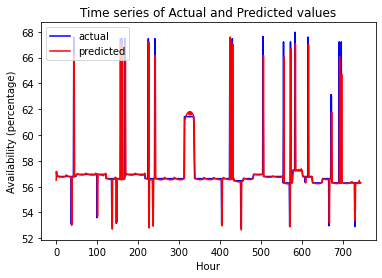




Preparing training data for carpark  ['DWST']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=0.1, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.2407167087056553
Mean Squared Error (Train): 166.12958077376865
Mean Squared Error (Test): 145.06771056668575


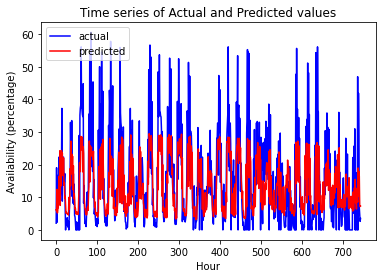




Preparing training data for carpark  ['DWSV']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=1, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.48611752025204447
Mean Squared Error (Train): 521.0240154571701
Mean Squared Error (Test): 187.18401741659366


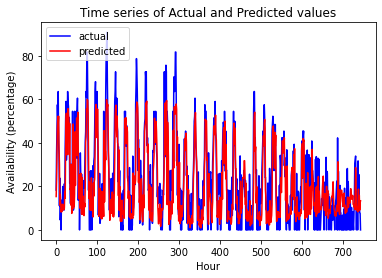




Preparing training data for carpark  ['DWVT']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8261889501215649
Mean Squared Error (Train): 1.7226844702669872
Mean Squared Error (Test): 14.124733464596341


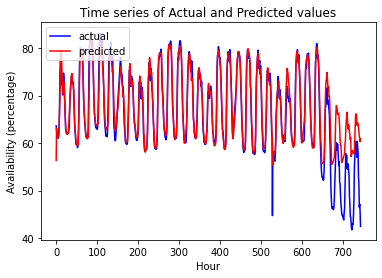




Preparing training data for carpark  ['EPL']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.6902321392666932
Mean Squared Error (Train): 112.58679968236011
Mean Squared Error (Test): 192.11604900557674


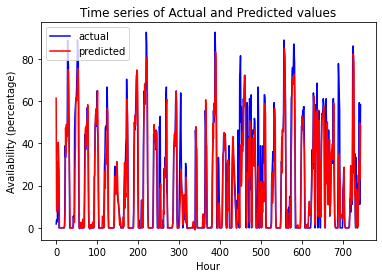




Preparing training data for carpark  ['EPM']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8302139510035069
Mean Squared Error (Train): 12.654112442303212
Mean Squared Error (Test): 14.244039314823645


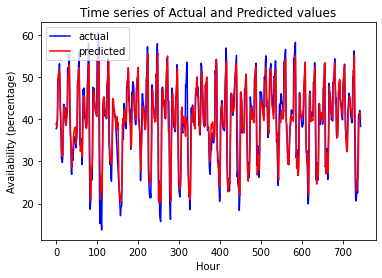




Preparing training data for carpark  ['GM1A']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.6674874599147796
Mean Squared Error (Train): 11.423052640467455
Mean Squared Error (Test): 5.287039061392235


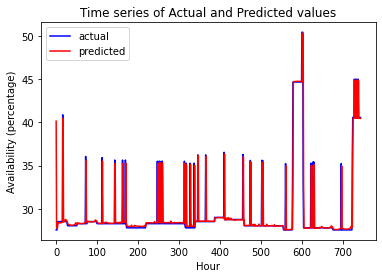




Preparing training data for carpark  ['GM1M']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.9235889047050589
Mean Squared Error (Train): 3.5596674930113474
Mean Squared Error (Test): 7.791268314763806


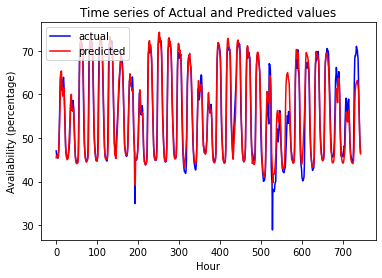




Preparing training data for carpark  ['GM2']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.9197020235514817
Mean Squared Error (Train): 50.09966056796507
Mean Squared Error (Test): 47.16509536487935


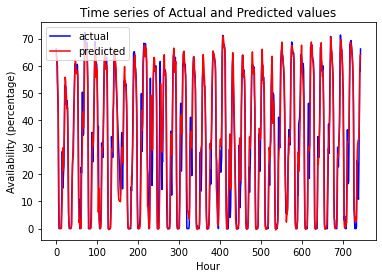




Preparing training data for carpark  ['GM2A']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.9065159948759235
Mean Squared Error (Train): 16.1575323119989
Mean Squared Error (Test): 13.650710007357624


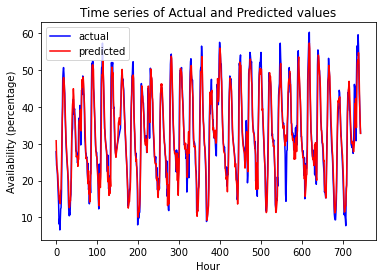




Preparing training data for carpark  ['GM3']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.9268829584674219
Mean Squared Error (Train): 78.09098984740031
Mean Squared Error (Test): 69.54487183101502


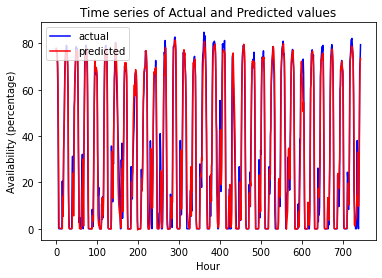




Preparing training data for carpark  ['GM5']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.946580635303041
Mean Squared Error (Train): 45.449155057408746
Mean Squared Error (Test): 45.43726692975451


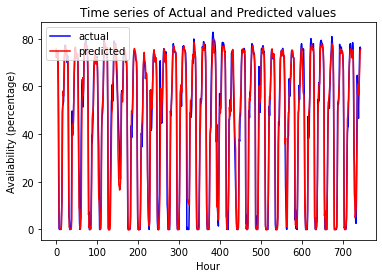




Preparing training data for carpark  ['GM6A']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8981385157730876
Mean Squared Error (Train): 12.420040738492029
Mean Squared Error (Test): 12.449382202989563


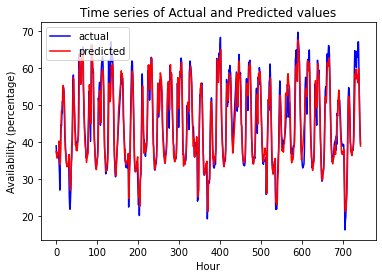




Preparing training data for carpark  ['GM6B']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8873367384151688
Mean Squared Error (Train): 16.225266890403848
Mean Squared Error (Test): 15.327169966358685


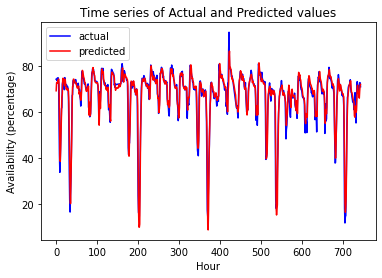




Preparing training data for carpark  ['H12']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -0.4325233014273566
Mean Squared Error (Train): 6.735194679936444
Mean Squared Error (Test): 4.939014858888896


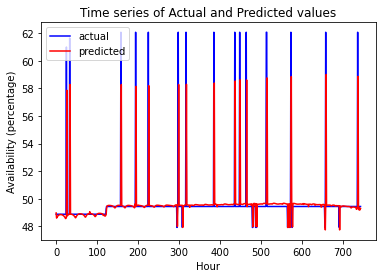




Preparing training data for carpark  ['H14']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -0.9603862125653793
Mean Squared Error (Train): 5.61322561918198
Mean Squared Error (Test): 6.565422409872658


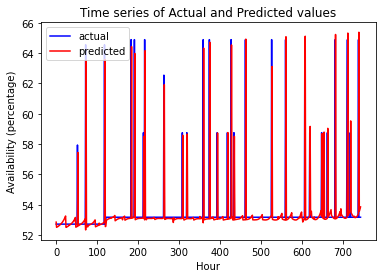




Preparing training data for carpark  ['H17']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8277798578355551
Mean Squared Error (Train): 24.54595375320506
Mean Squared Error (Test): 16.503971036448828


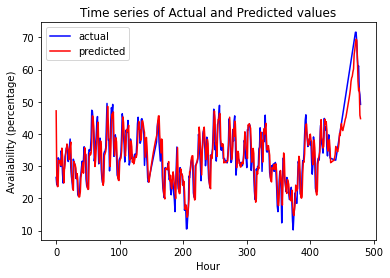




Preparing training data for carpark  ['H18']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8892068906458409
Mean Squared Error (Train): 25.1521763673673
Mean Squared Error (Test): 12.502625721260427


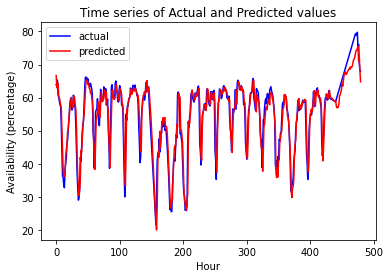




Preparing training data for carpark  ['H3']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -1.1225548527666458
Mean Squared Error (Train): 20.42042298250902
Mean Squared Error (Test): 15.711631972682056


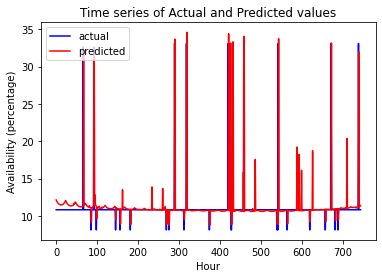




Preparing training data for carpark  ['H4']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.7694127338815839
Mean Squared Error (Train): 63.381139761148326
Mean Squared Error (Test): 216.99150093929228


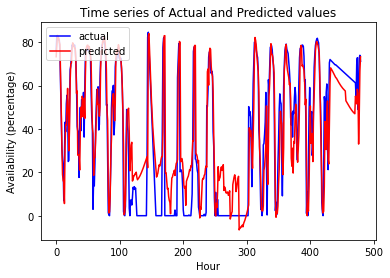




Preparing training data for carpark  ['H6']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8643929218372658
Mean Squared Error (Train): 9.798868901098674
Mean Squared Error (Test): 6.199147563701628


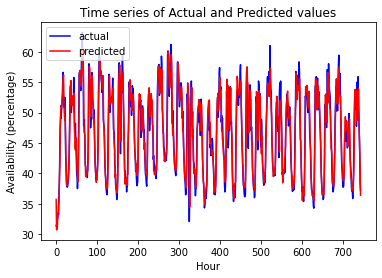




Preparing training data for carpark  ['H8']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.911655942277693
Mean Squared Error (Train): 6.26312829439006
Mean Squared Error (Test): 6.650164108572338


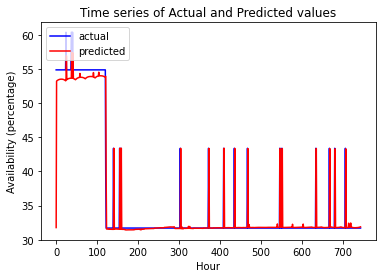




Preparing training data for carpark  ['HCM']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -0.49659419793114723
Mean Squared Error (Train): 2.8396547227654567
Mean Squared Error (Test): 4.577187919265901


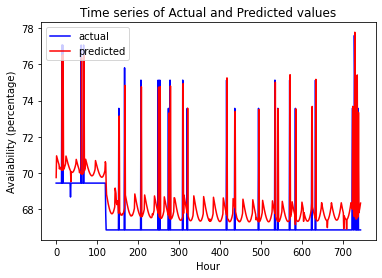




Preparing training data for carpark  ['HE1']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=1, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.048779649833523786
Mean Squared Error (Train): 316.48299506535227
Mean Squared Error (Test): 262.5620368139442


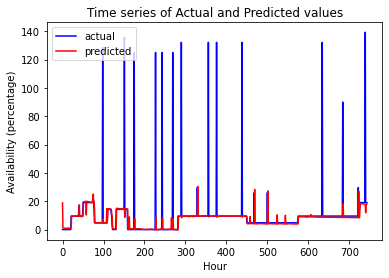




Preparing training data for carpark  ['HE12']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.9056848048844565
Mean Squared Error (Train): 36.2013473139685
Mean Squared Error (Test): 49.74115674673861


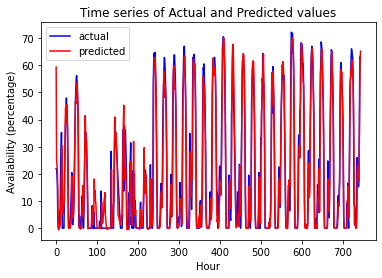




Preparing training data for carpark  ['HE17']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.887425502713622
Mean Squared Error (Train): 8.54154964859323
Mean Squared Error (Test): 9.00630479505236


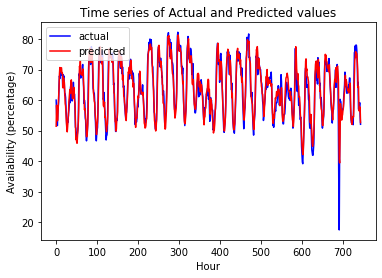




Preparing training data for carpark  ['HE19']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.7080438261995552
Mean Squared Error (Train): 4.050987082672995
Mean Squared Error (Test): 9.147338164589165


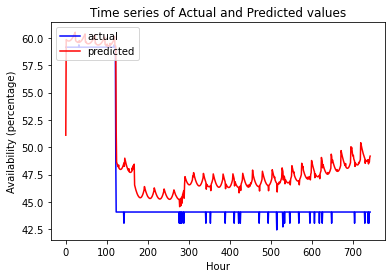




Preparing training data for carpark  ['HE24']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.6088386354959336
Mean Squared Error (Train): 20.757100700424395
Mean Squared Error (Test): 6.031936809618524


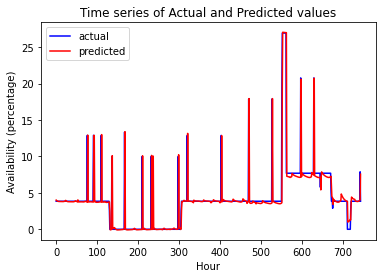




Preparing training data for carpark  ['HE3']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -1.819910964743202
Mean Squared Error (Train): 79.76885608937478
Mean Squared Error (Test): 4.32590424140494


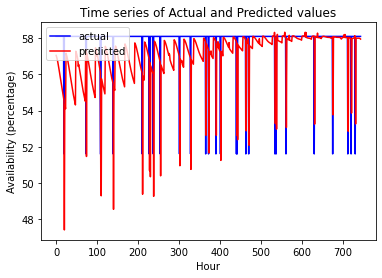




Preparing training data for carpark  ['HE4']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.21607094400323623
Mean Squared Error (Train): 19.931603176701326
Mean Squared Error (Test): 905.5456941678442


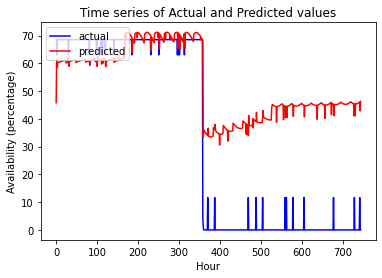




Preparing training data for carpark  ['HE9']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.7419577983953285
Mean Squared Error (Train): 38.5517140798938
Mean Squared Error (Test): 17.201288140014444


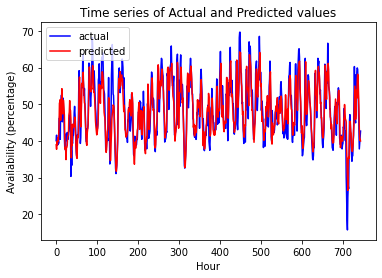




Preparing training data for carpark  ['HLM']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.9307787956062495
Mean Squared Error (Train): 14.600359471072402
Mean Squared Error (Test): 54.83598232486535


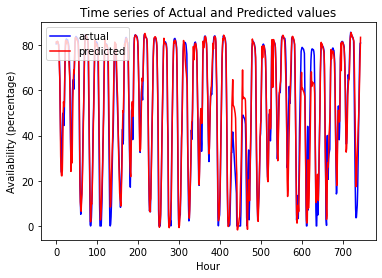




Preparing training data for carpark  ['HRM']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.94114352363672
Mean Squared Error (Train): 2.13248298754922
Mean Squared Error (Test): 4.607942801921517


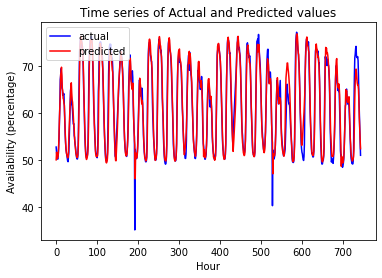




Preparing training data for carpark  ['HVM']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.9506859834738849
Mean Squared Error (Train): 4.53487942989501
Mean Squared Error (Test): 4.1216768314623735


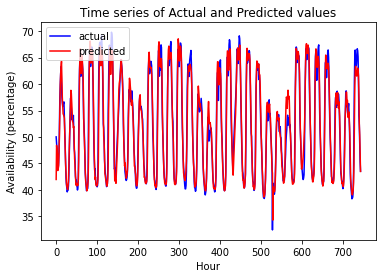




Preparing training data for carpark  ['JBM']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.9489415654897471
Mean Squared Error (Train): 3.0119429325430995
Mean Squared Error (Test): 2.3952919809887234


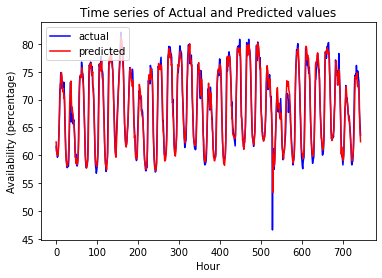




Preparing training data for carpark  ['JBM2']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8532640035125549
Mean Squared Error (Train): 18.18213761129052
Mean Squared Error (Test): 18.275196566987535


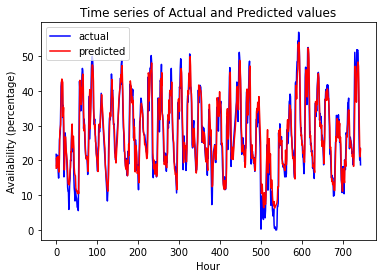




Preparing training data for carpark  ['JKM']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=1, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -232.2687788419681
Mean Squared Error (Train): 9.244596359816697
Mean Squared Error (Test): 76.4626120848769


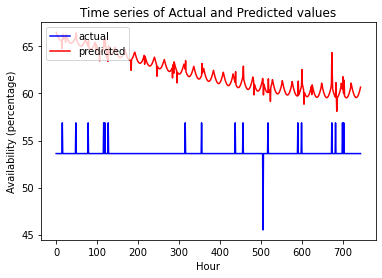




Preparing training data for carpark  ['JKS']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.9104616243050421
Mean Squared Error (Train): 20.46303251514956
Mean Squared Error (Test): 9.026391821807948


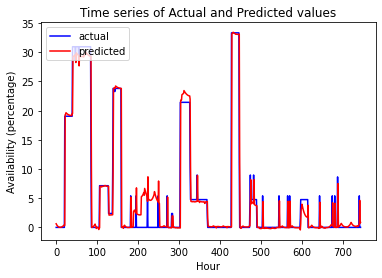




Preparing training data for carpark  ['JMB1']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8885615249624264
Mean Squared Error (Train): 1.4872953192179867
Mean Squared Error (Test): 6.730350288263963


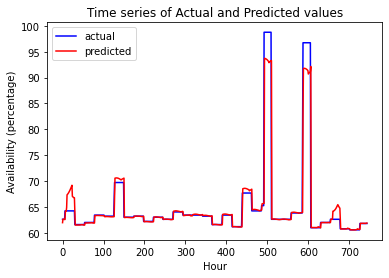




Preparing training data for carpark  ['JMB2']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=1, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.7089554700932834
Mean Squared Error (Train): 3.2587940373398907
Mean Squared Error (Test): 2.6708359332593496


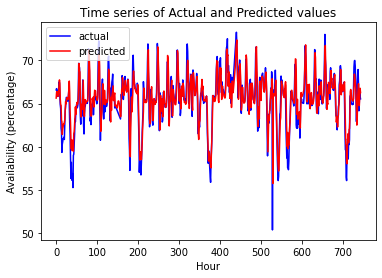




Preparing training data for carpark  ['JMB3']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.9470294201564423
Mean Squared Error (Train): 4.85206048589169
Mean Squared Error (Test): 5.583628037120999


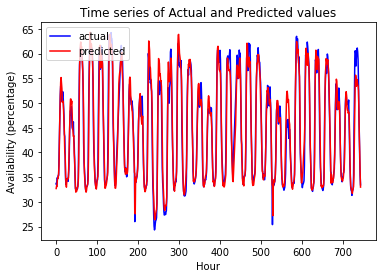




Preparing training data for carpark  ['JRTM']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -1.049407790286863
Mean Squared Error (Train): 1.971696075659706
Mean Squared Error (Test): 0.7180966943648607


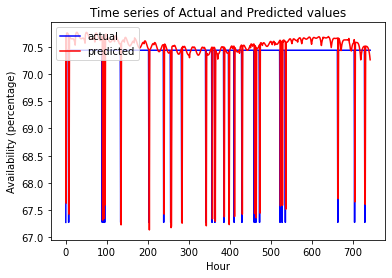




Preparing training data for carpark  ['KAM']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.917910030571585
Mean Squared Error (Train): 75.9962327733182
Mean Squared Error (Test): 49.45571235527937


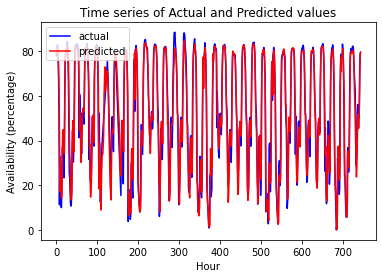




Preparing training data for carpark  ['KAML']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.5763289624748252
Mean Squared Error (Train): 339.8498515287715
Mean Squared Error (Test): 336.7507532372106


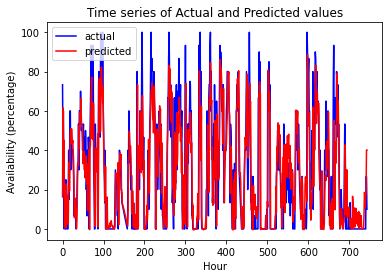




Preparing training data for carpark  ['KAS']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8618480104295057
Mean Squared Error (Train): 101.3657518258709
Mean Squared Error (Test): 118.96254493664263


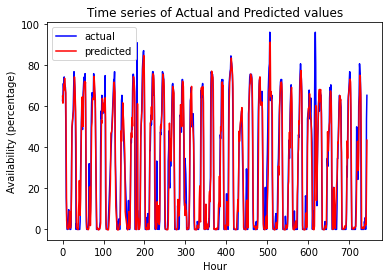




Preparing training data for carpark  ['KTM']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.9512557915271861
Mean Squared Error (Train): 4.94069908703589
Mean Squared Error (Test): 9.11764211750673


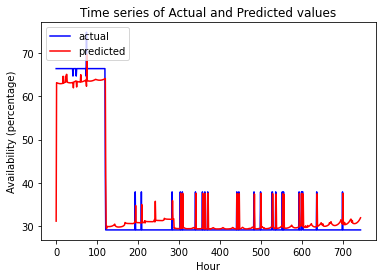




Preparing training data for carpark  ['KTM2']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.9602481056107686
Mean Squared Error (Train): 2.129720019204218
Mean Squared Error (Test): 1.6566366656101663


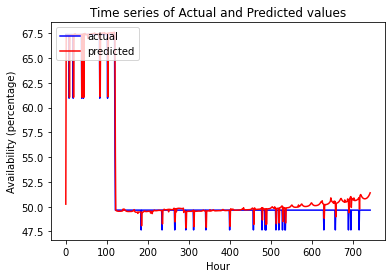




Preparing training data for carpark  ['KTM3']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=1, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -1.693009539024637
Mean Squared Error (Train): 26.209073079256974
Mean Squared Error (Test): 0.4855457270870969


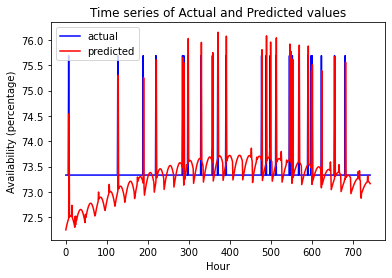




Preparing training data for carpark  ['KTM4']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=1, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -1.1253696860844027
Mean Squared Error (Train): 4.997625312467045
Mean Squared Error (Test): 4.394160403331675


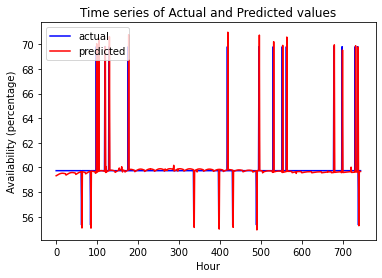




Preparing training data for carpark  ['KTM5']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -12.9477819864438
Mean Squared Error (Train): 5.362485400331769
Mean Squared Error (Test): 34.96803330366054


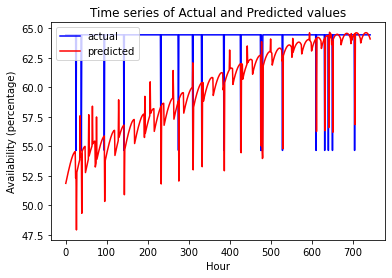




Preparing training data for carpark  ['LBM']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -0.7096750126447668
Mean Squared Error (Train): 9.23176435001323
Mean Squared Error (Test): 3.5781971170476985


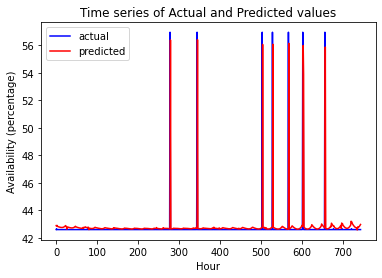




Preparing training data for carpark  ['MLM']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=0.01, gamma=1)
Getting arrays for testing

Testing Results: 
R-squared: -30.18254662696462
Mean Squared Error (Train): 575.864717304485
Mean Squared Error (Test): 2107.864225566196


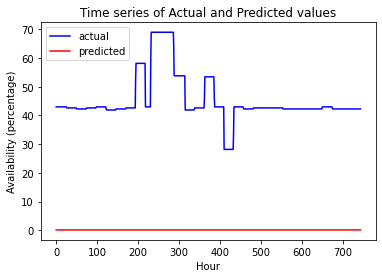




Preparing training data for carpark  ['MLM1']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.7403653294049067
Mean Squared Error (Train): 6.368326981487003
Mean Squared Error (Test): 9.916944103636025


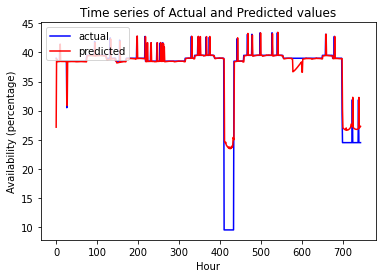




Preparing training data for carpark  ['PDQ5']
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -1.4314613995072363
Mean Squared Error (Train): 11.466033442358231
Mean Squared Error (Test): 491.733966196893


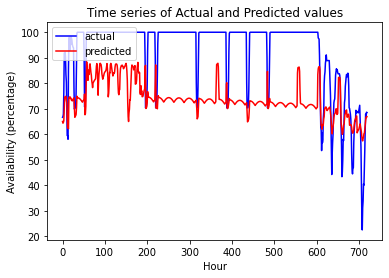




Preparing training data for carpark  ['PRM']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.9057029537349907
Mean Squared Error (Train): 18.74846471061218
Mean Squared Error (Test): 69.29369005171709


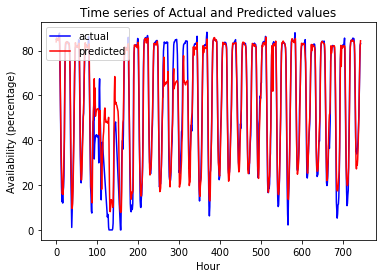




Preparing training data for carpark  ['Q16']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.5644080019496021
Mean Squared Error (Train): 212.1399897660279
Mean Squared Error (Test): 58.67170675357974


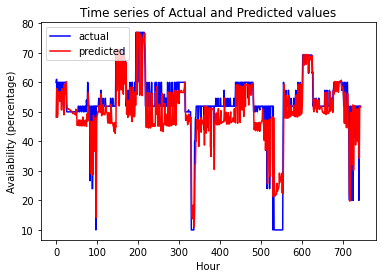




Preparing training data for carpark  ['Q17']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8718692471239993
Mean Squared Error (Train): 100.6785979432091
Mean Squared Error (Test): 1.6862179110850133


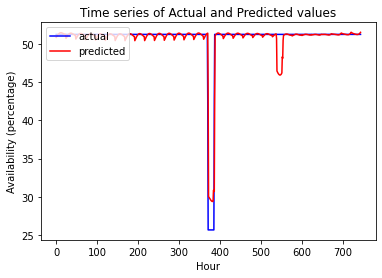




Preparing training data for carpark  ['Q19']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.7750123908578347
Mean Squared Error (Train): 38.98314686005688
Mean Squared Error (Test): 18.120575698016147


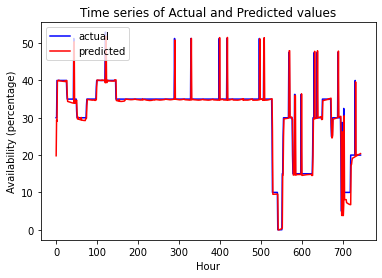




Preparing training data for carpark  ['Q41']
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8037455410675693
Mean Squared Error (Train): 13.10187466349736
Mean Squared Error (Test): 43.14795653693034


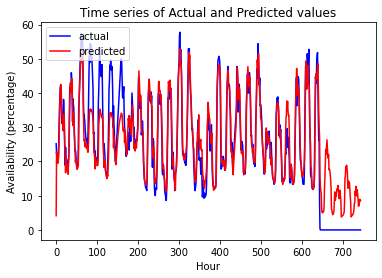




Preparing training data for carpark  ['Q65']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.9409769157774895
Mean Squared Error (Train): 32.33127332421108
Mean Squared Error (Test): 2.6948851858030016


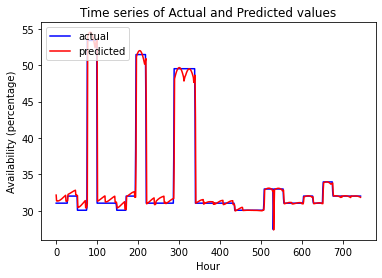




Preparing training data for carpark  ['Q66']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.6836766598023456
Mean Squared Error (Train): 34.81872861914398
Mean Squared Error (Test): 37.57328492467002


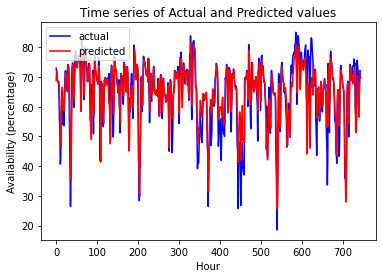




Preparing training data for carpark  ['Q67']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.7837072798421746
Mean Squared Error (Train): 47.21636146827436
Mean Squared Error (Test): 44.490802270730995


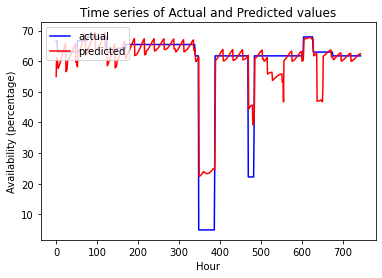




Preparing training data for carpark  ['Q68']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.7680885865199787
Mean Squared Error (Train): 29.747882444571644
Mean Squared Error (Test): 3.6099288067174164


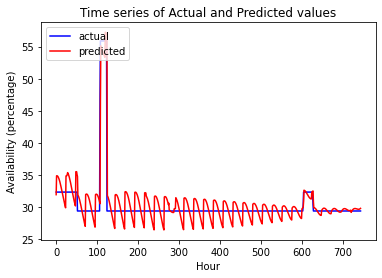




Preparing training data for carpark  ['Q70']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8282900490082307
Mean Squared Error (Train): 60.14218999580231
Mean Squared Error (Test): 8.602482644999382


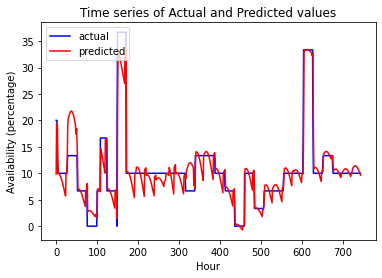




Preparing training data for carpark  ['Q73']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8813410363731202
Mean Squared Error (Train): 100.18248598345068
Mean Squared Error (Test): 10.934699667176881


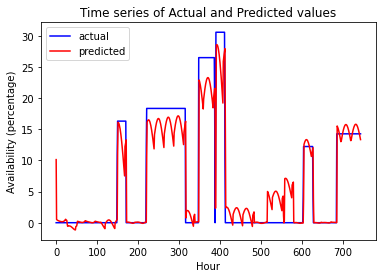




Preparing training data for carpark  ['Q75M']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.7469666387292652
Mean Squared Error (Train): 3.6719291973488253
Mean Squared Error (Test): 9.304348338984353


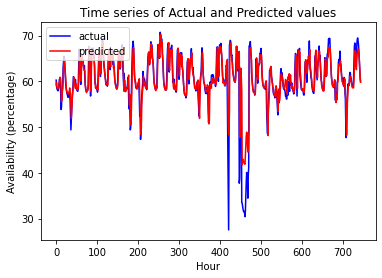




Preparing training data for carpark  ['Q77M']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.9623138360563661
Mean Squared Error (Train): 4.6980377444584605
Mean Squared Error (Test): 2.874548061071113


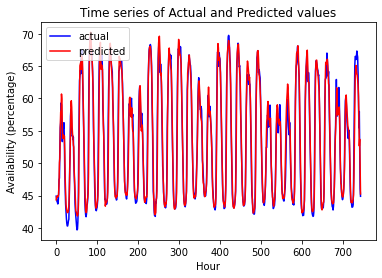




Preparing training data for carpark  ['Q8']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8211757762287571
Mean Squared Error (Train): 9.360749670298352
Mean Squared Error (Test): 6.462317041649745


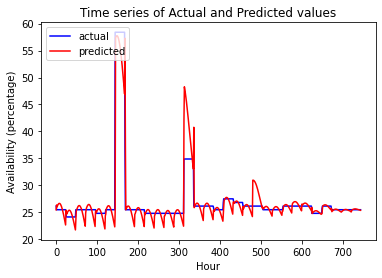




Preparing training data for carpark  ['Q80']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8896784103391334
Mean Squared Error (Train): 49.729761817415714
Mean Squared Error (Test): 66.586222756958


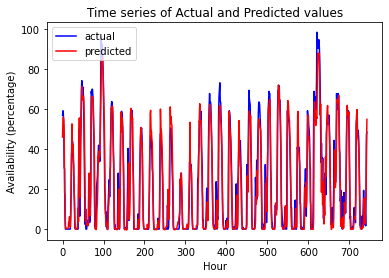




Preparing training data for carpark  ['Q81']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.9263410683971727
Mean Squared Error (Train): 50.79489848981877
Mean Squared Error (Test): 69.21087355382392


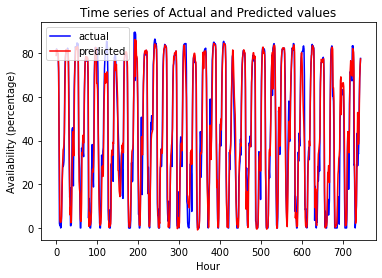




Preparing training data for carpark  ['Q84']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.7345861999533666
Mean Squared Error (Train): 36.75291707370708
Mean Squared Error (Test): 28.986477062495126


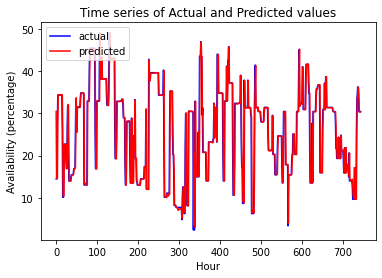




Preparing training data for carpark  ['Q85']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8448184711816613
Mean Squared Error (Train): 32.89811268165471
Mean Squared Error (Test): 85.66094655550128


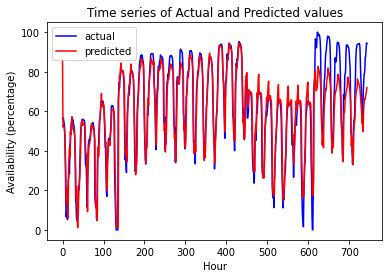




Preparing training data for carpark  ['Q86']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=1, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.3988328247828242
Mean Squared Error (Train): 7.911335211990186
Mean Squared Error (Test): 2.064523819483838


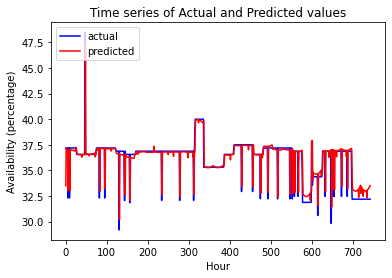




Preparing training data for carpark  ['Q87']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8612882228782786
Mean Squared Error (Train): 9.036886045123898
Mean Squared Error (Test): 25.98359812638452


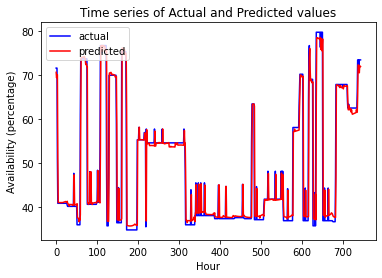




Preparing training data for carpark  ['Q88']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.45661056455698046
Mean Squared Error (Train): 5.035561570400681
Mean Squared Error (Test): 0.03842673652657076


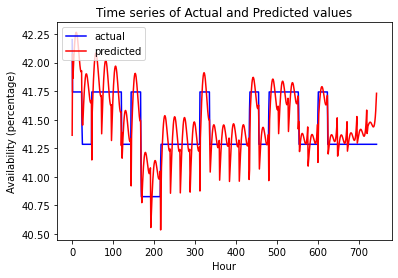




Preparing training data for carpark  ['Q89']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8439120256074006
Mean Squared Error (Train): 21.351246857869647
Mean Squared Error (Test): 80.2071305744631


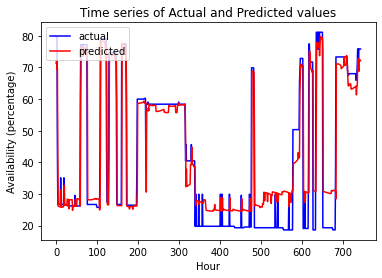




Preparing training data for carpark  ['Q94']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8011710164811674
Mean Squared Error (Train): 53.47336459121064
Mean Squared Error (Test): 43.95143924153558


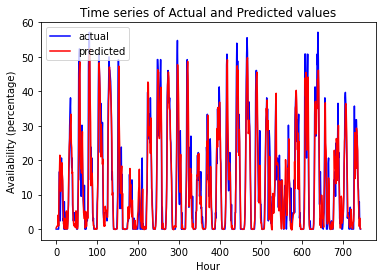




Preparing training data for carpark  ['Q96']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -1.299371695523997
Mean Squared Error (Train): 20.887320570353776
Mean Squared Error (Test): 1.1233510531101154


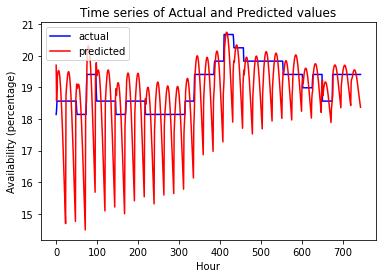




Preparing training data for carpark  ['RHM']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.7938716109934377
Mean Squared Error (Train): 15.484978000003633
Mean Squared Error (Test): 18.65785161688711


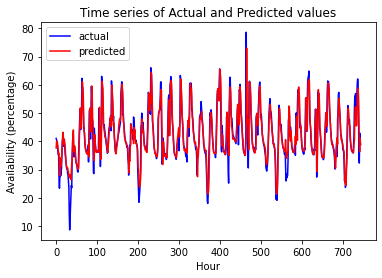




Preparing training data for carpark  ['RHM2']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.48184292670283113
Mean Squared Error (Train): 8.34561635074753
Mean Squared Error (Test): 6.726775687581115


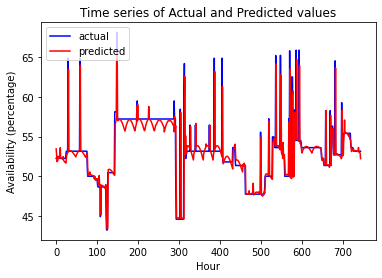




Preparing training data for carpark  ['RHM3']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.896038741492299
Mean Squared Error (Train): 6.781054023911118
Mean Squared Error (Test): 2.143123535328204


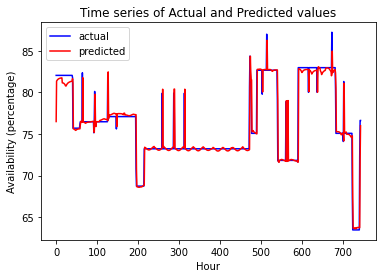




Preparing training data for carpark  ['RHM4']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8589688639864419
Mean Squared Error (Train): 15.092630193448516
Mean Squared Error (Test): 15.294395150960677


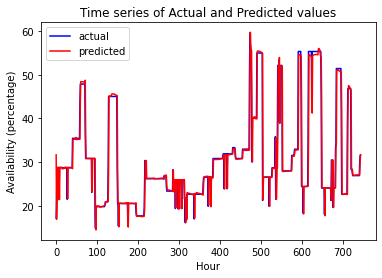




Preparing training data for carpark  ['RHS']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=0.01, gamma=1)
Getting arrays for testing

Testing Results: 
R-squared: -0.012074915045222623
Mean Squared Error (Train): 10.450135353924285
Mean Squared Error (Test): 2.063573863410768


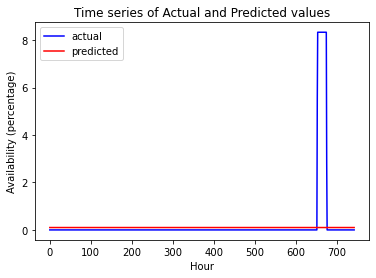




Preparing training data for carpark  ['SAM']
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.797584813596777
Mean Squared Error (Train): 7.008024339337474
Mean Squared Error (Test): 6.460879487147114


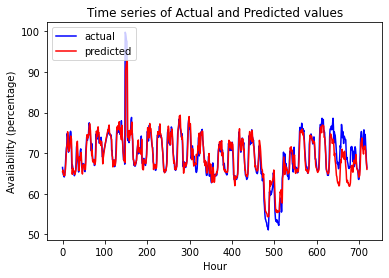




Preparing training data for carpark  ['SAM2']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=1, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8517097460624221
Mean Squared Error (Train): 16.73866976377264
Mean Squared Error (Test): 4.984446136095273


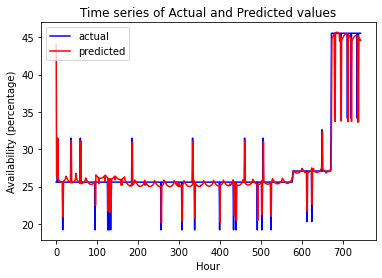




Preparing training data for carpark  ['SLS']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.92148647943521
Mean Squared Error (Train): 53.49607480281497
Mean Squared Error (Test): 45.5688564478597


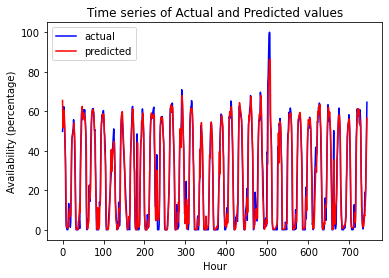




Preparing training data for carpark  ['SMM']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=0.1, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.11877066702569938
Mean Squared Error (Train): 182.7393009463367
Mean Squared Error (Test): 258.17223337460416


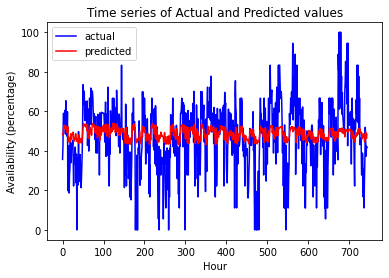




Preparing training data for carpark  ['SPM']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -0.07169911135557294
Mean Squared Error (Train): 10.371983374109075
Mean Squared Error (Test): 13.035413879334882


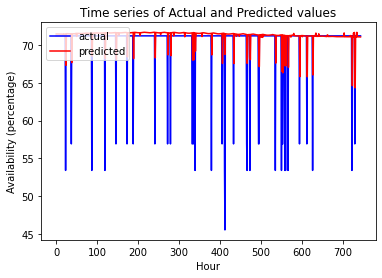




Preparing training data for carpark  ['SPS']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -1.255956722613076
Mean Squared Error (Train): 7.735969089331399
Mean Squared Error (Test): 4.041628399658979


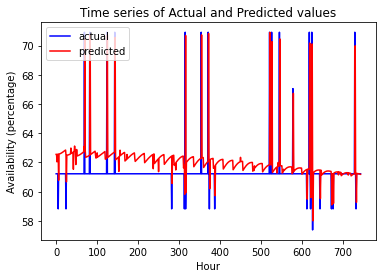




Preparing training data for carpark  ['STAM']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -0.5391688785004449
Mean Squared Error (Train): 7.364765419165484
Mean Squared Error (Test): 3.135758026356955


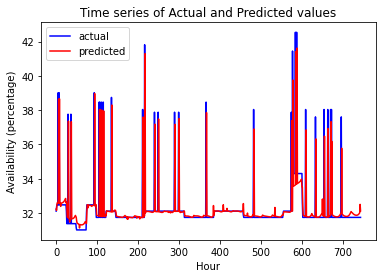




Preparing training data for carpark  ['STM1']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.7242468720057862
Mean Squared Error (Train): 9.709450533671195
Mean Squared Error (Test): 2.8864203265925696


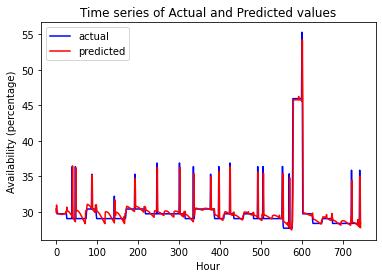




Preparing training data for carpark  ['STM2']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.7609166518711437
Mean Squared Error (Train): 5.714397676176334
Mean Squared Error (Test): 2.8719843642824587


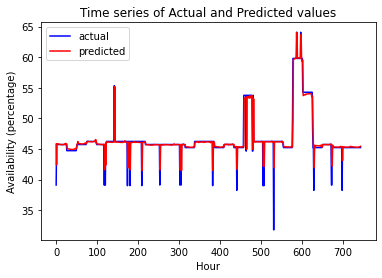




Preparing training data for carpark  ['STM3']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -0.03223275346183896
Mean Squared Error (Train): 3.819210398626863
Mean Squared Error (Test): 9.244672373706733


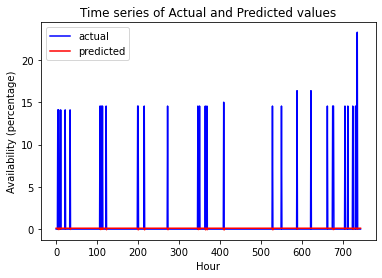




Preparing training data for carpark  ['TB1']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.9244016923230105
Mean Squared Error (Train): 2.9452974793867517
Mean Squared Error (Test): 1.5185407176795385


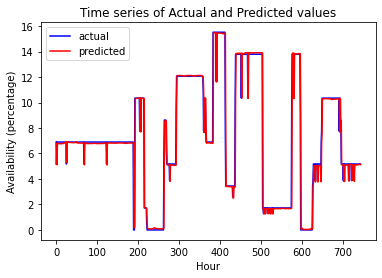




Preparing training data for carpark  ['TB10']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -0.8379298386597591
Mean Squared Error (Train): 14.905416505355934
Mean Squared Error (Test): 12.795725304470185


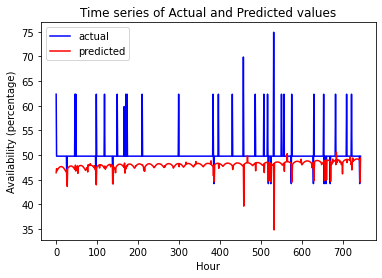




Preparing training data for carpark  ['TB11']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8739360645523925
Mean Squared Error (Train): 7.665491109766173
Mean Squared Error (Test): 4.79895262454788


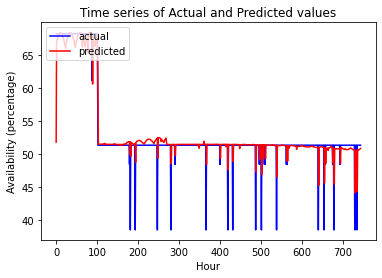




Preparing training data for carpark  ['TB14']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.564368829499797
Mean Squared Error (Train): 28.47247034381341
Mean Squared Error (Test): 31.914242256562908


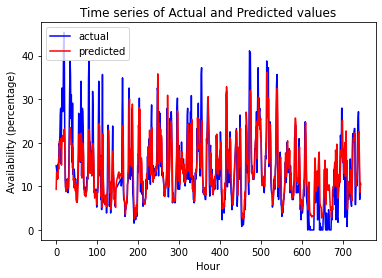




Preparing training data for carpark  ['TB17']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8341018226669143
Mean Squared Error (Train): 22.149366873749113
Mean Squared Error (Test): 26.467729426218646


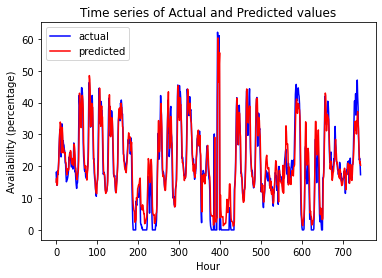




Preparing training data for carpark  ['TB18']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8662254619034958
Mean Squared Error (Train): 22.447182533512525
Mean Squared Error (Test): 31.608079639783917


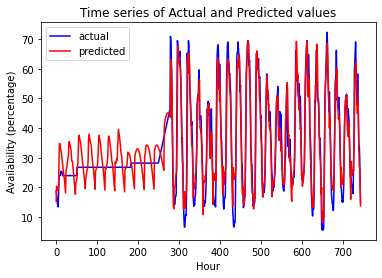




Preparing training data for carpark  ['TB19']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.7695168449011046
Mean Squared Error (Train): 19.624008861038494
Mean Squared Error (Test): 18.685344884671327


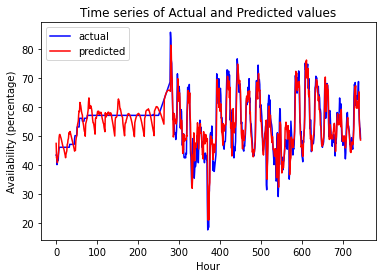




Preparing training data for carpark  ['TB2']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.7919809943934435
Mean Squared Error (Train): 6.029320147738427
Mean Squared Error (Test): 8.240293774704854


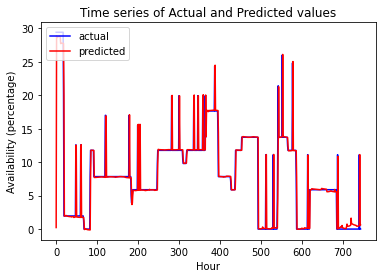




Preparing training data for carpark  ['TB22']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -1.065892665865146
Mean Squared Error (Train): 69.08661440904046
Mean Squared Error (Test): 27.25197831427318


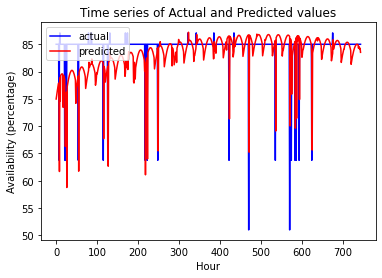




Preparing training data for carpark  ['TB23']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -3.4446164236958463
Mean Squared Error (Train): 15.994304763758146
Mean Squared Error (Test): 80.54343131250567


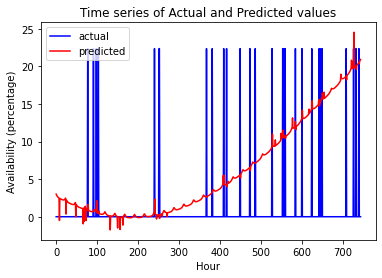




Preparing training data for carpark  ['TB28']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8206321950165504
Mean Squared Error (Train): 56.43148638121097
Mean Squared Error (Test): 9.360268477786818


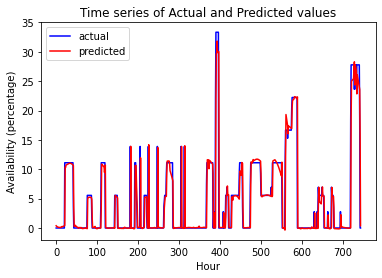




Preparing training data for carpark  ['TB3']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.960174491763408
Mean Squared Error (Train): 3.0934891869010532
Mean Squared Error (Test): 3.4851024452689314


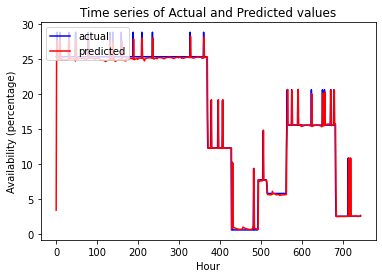




Preparing training data for carpark  ['TB6']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -62.28086481485682
Mean Squared Error (Train): 5.291394991460343
Mean Squared Error (Test): 11.524385687272238


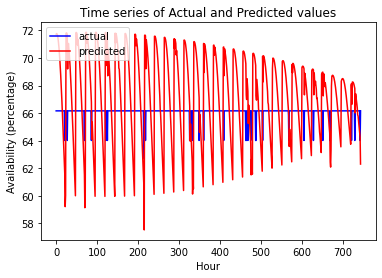




Preparing training data for carpark  ['TB7']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -0.7243959953471979
Mean Squared Error (Train): 6.293435932463449
Mean Squared Error (Test): 5.541524828438207


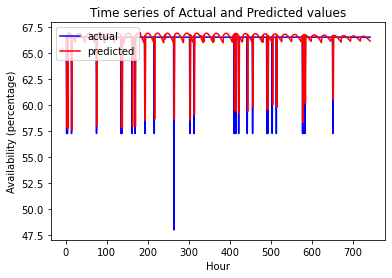




Preparing training data for carpark  ['TB8']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -16.692502552659267
Mean Squared Error (Train): 11.575235031098146
Mean Squared Error (Test): 2.0275891205290937


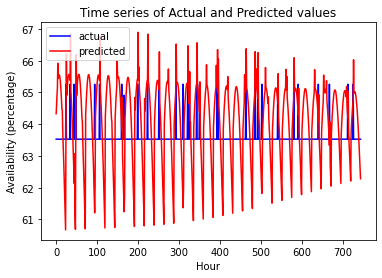




Preparing training data for carpark  ['TB9']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.961710676474274
Mean Squared Error (Train): 11.787584906247663
Mean Squared Error (Test): 2.762121246619225


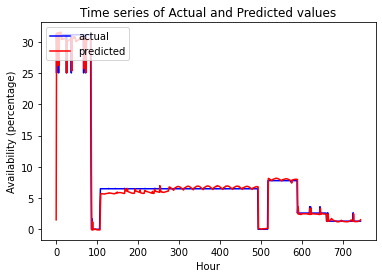




Preparing training data for carpark  ['TBC2']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.9305043232985898
Mean Squared Error (Train): 9.541166476362157
Mean Squared Error (Test): 5.0439049376645855


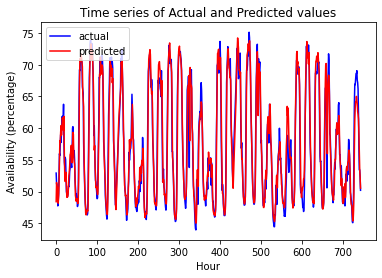




Preparing training data for carpark  ['TBC3']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=1, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -13.243687958609033
Mean Squared Error (Train): 6.948019695397483
Mean Squared Error (Test): 90.34266647535142


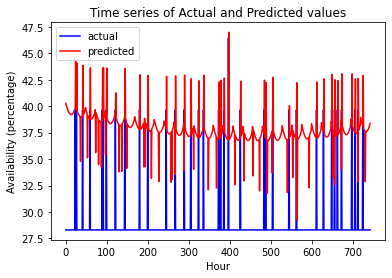




Preparing training data for carpark  ['TBCM']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.5601179711592279
Mean Squared Error (Train): 1.647496288628417
Mean Squared Error (Test): 1.4738779930490102


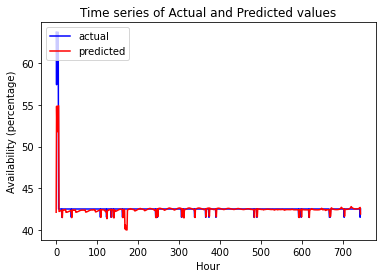




Preparing training data for carpark  ['TBL']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.6791948086047968
Mean Squared Error (Train): 0.031598997004188646
Mean Squared Error (Test): 0.024620187142983016


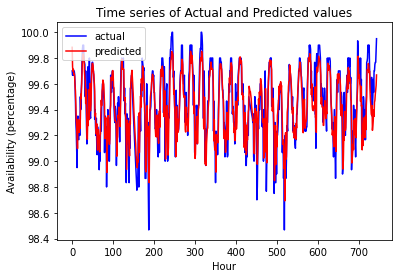




Preparing training data for carpark  ['TBM']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.9145437661760951
Mean Squared Error (Train): 5.624501387939465
Mean Squared Error (Test): 4.241761300007057


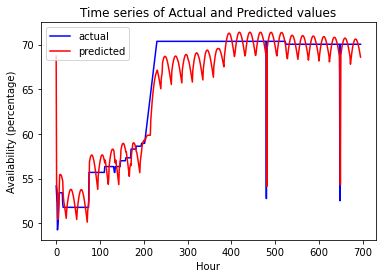




Preparing training data for carpark  ['TBM2']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -12.025124670893211
Mean Squared Error (Train): 19.955137210039656
Mean Squared Error (Test): 43.84090773772646


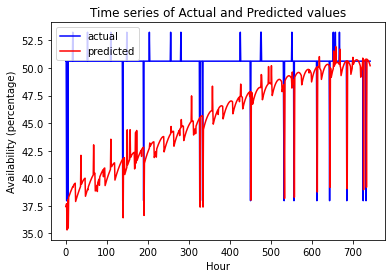




Preparing training data for carpark  ['TBM3']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -0.8419850302762806
Mean Squared Error (Train): 1.759196052722793
Mean Squared Error (Test): 1.909723673947253


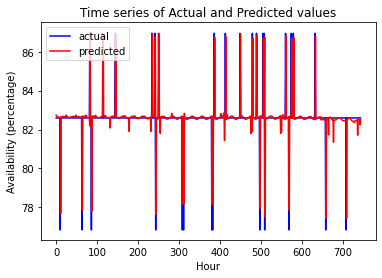




Preparing training data for carpark  ['TBM4']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=1, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -4.031817257201347
Mean Squared Error (Train): 8.260414834704347
Mean Squared Error (Test): 6.418681021557082


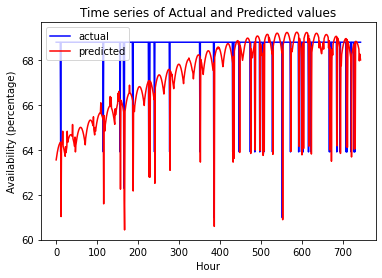




Preparing training data for carpark  ['TBM5']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.9548406118924327
Mean Squared Error (Train): 13.434226765888162
Mean Squared Error (Test): 7.590354548042946


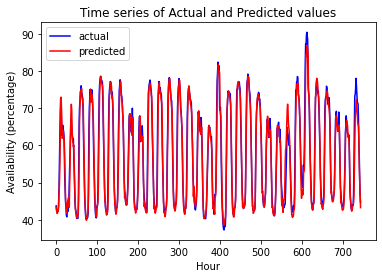




Preparing training data for carpark  ['TBM6']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=1, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.9014374062645528
Mean Squared Error (Train): 5.448679387535743
Mean Squared Error (Test): 2.088446211057577


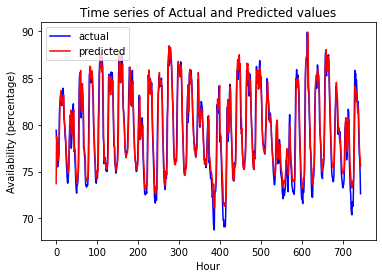




Preparing training data for carpark  ['TBM7']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=1, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.949907488361064
Mean Squared Error (Train): 8.939927786338483
Mean Squared Error (Test): 2.1832977633368515


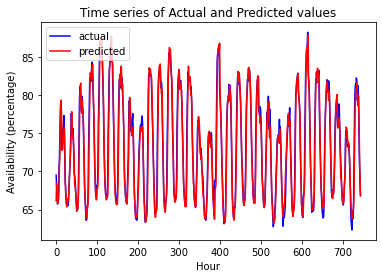




Preparing training data for carpark  ['TBM8']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.9493458396064327
Mean Squared Error (Train): 3.7067337891078322
Mean Squared Error (Test): 7.592221093037407


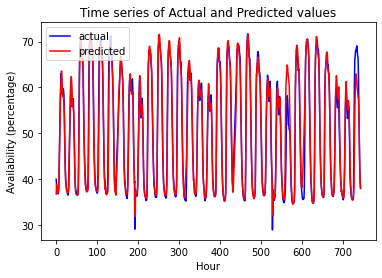




Preparing training data for carpark  ['TBMT']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8032850355303331
Mean Squared Error (Train): 23.91289674290111
Mean Squared Error (Test): 11.889946388623425


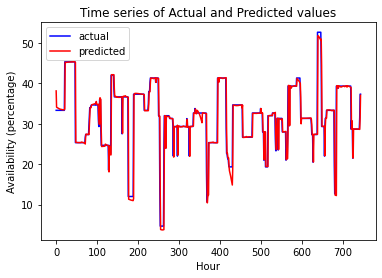




Preparing training data for carpark  ['TE1']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=1, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -1.1421017557957378
Mean Squared Error (Train): 22.986447490857252
Mean Squared Error (Test): 8.618076473807767


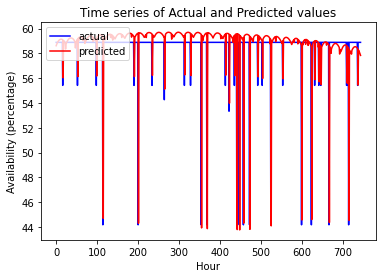




Preparing training data for carpark  ['TE13']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.8583968105897697
Mean Squared Error (Train): 23.261695736585374
Mean Squared Error (Test): 26.969292009296936


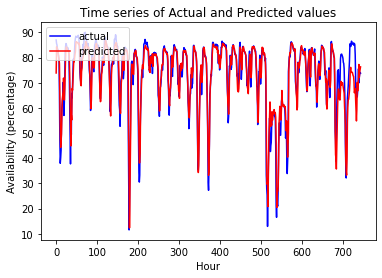




Preparing training data for carpark  ['TE14']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.9110477470459823
Mean Squared Error (Train): 17.549093466927943
Mean Squared Error (Test): 17.296977868666513


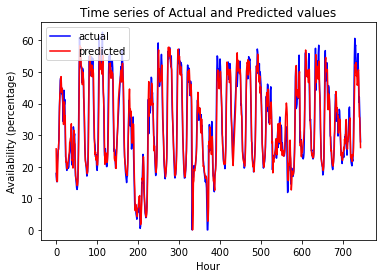




Preparing training data for carpark  ['TE2']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.9315572236824615
Mean Squared Error (Train): 3.849043623199261
Mean Squared Error (Test): 4.6805947311261304


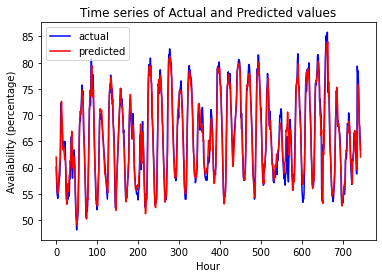




Preparing training data for carpark  ['TE25']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.52878126715928
Mean Squared Error (Train): 11.389782989593462
Mean Squared Error (Test): 85.13353914767346


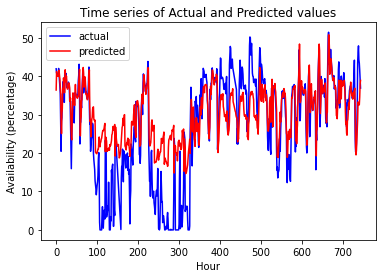




Preparing training data for carpark  ['TE3']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.01)
Getting arrays for testing

Testing Results: 
R-squared: 0.07761047995848758
Mean Squared Error (Train): 3.0938426635950855
Mean Squared Error (Test): 178.4951579344277


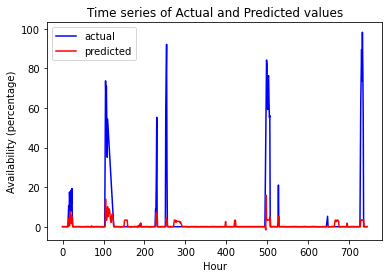




Preparing training data for carpark  ['TE4']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.6797744902169951
Mean Squared Error (Train): 49.300849291522404
Mean Squared Error (Test): 19.991144919546443


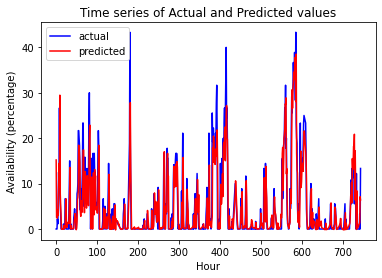




Preparing training data for carpark  ['TPL']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.5300232334248004
Mean Squared Error (Train): 68.41828914961593
Mean Squared Error (Test): 162.00173712363272


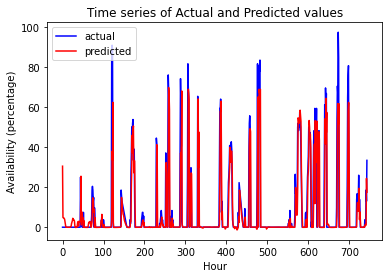




Preparing training data for carpark  ['TPM']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: 0.9354127774904872
Mean Squared Error (Train): 15.295227841102715
Mean Squared Error (Test): 16.752771765715853


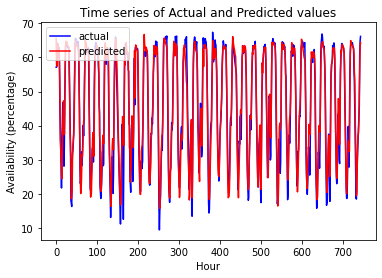




Preparing training data for carpark  ['YHS']
	Collating data for  2019  year and  10  month.
	Collating data for  2021  year and  10  month.
	Collating data for  2022  year and  8  month.
	Collating data for  2022  year and  9  month.
Preparing test data
Getting arrays for training
Fitting the model
Fitting 3 folds for each of 16 candidates, totalling 48 fits
	 SVR(C=10, gamma=0.001)
Getting arrays for testing

Testing Results: 
R-squared: -0.9450847629179284
Mean Squared Error (Train): 15.841668988389472
Mean Squared Error (Test): 5.457231946579838


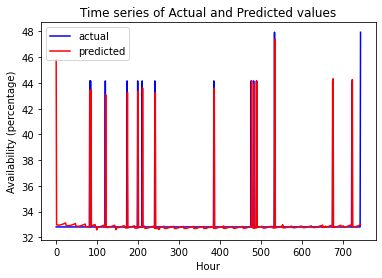

In [ ]:
for i in range(0, 176):    
    carpark = train_data_groups[i:i+1]
    print('Preparing training data for carpark ', carpark)
    train_data_1 = train_data[train_data['carpark_number'].isin(carpark)]
    data = pd.DataFrame(columns = ['day', 'hour', 'percent_lots_available'])
    train_data_all = pd.DataFrame()
    
    train_data_yearly = train_data_1.groupby("year", as_index = False)
    
    for year in train_data_yearly.groups.keys():
#         if year == 2019 or year == 2021:
#             continue
        train_data_monthly = train_data_yearly.get_group(year).groupby("month", as_index = False)

        for month in train_data_monthly.groups.keys(): 
#             if month == 8:
#                 continue
            print('\tCollating data for ', year, ' year and ', month, ' month.')
            train_data_daily = train_data_monthly.get_group(month).groupby("day", as_index = False)
            
            train_data_1_agg = pd.DataFrame()
            
            for day in train_data_daily.groups.keys():
                day_data = train_data_daily.get_group(day)
                hourly_data_day = day_data.groupby('hour', as_index = False)['percent_lots_available'].mean()
#                 title = "Day: " + str(day)
#                 hourly_data_day.plot(title = title, y = "percent_lots_available", xlabel = 'hour', \
#                          ylabel = 'Lots available (percentage)', xticks = hourly_data_day["hour"])
                hourly_data = []
                hour = []
                for i in range(0, 24):
                    hour.append(i)
                    value = np.NaN if hourly_data_day[hourly_data_day['hour'] == i]['percent_lots_available'].empty \
                    else hourly_data_day[hourly_data_day['hour'] == i]['percent_lots_available'].iloc[0]
                    hourly_data.append(value)

                data['hour'] = hour
                data['percent_lots_available'] = hourly_data
                data['day'] = day
                train_data_1_agg = train_data_1_agg.append(data, ignore_index=True)

#             print(train_data_1_agg)
            train_data_1_agg.interpolate(method='linear', limit_direction='both', inplace = True)
#             print(train_data_1_agg)

            train_data_1_agg['lag_1'] = train_data_1_agg['percent_lots_available'].shift(1)
            train_data_1_agg['lag_168'] = train_data_1_agg['percent_lots_available'].shift(168)
#             print(train_data_1_agg.tail(1)['percent_lots_available'])
            train_data_1_agg['lag_1'].iloc[0] = train_data_1_agg.tail(1)['percent_lots_available']
            train_data_1_agg['lag_168'].iloc[:168] = train_data_1_agg.tail(168)['percent_lots_available']
#             print(train_data_1_agg)

        train_data_all = train_data_all.append(train_data_1_agg)
    
    print('Preparing test data')
    test_data_1 = test_data[test_data['carpark_number'].isin(carpark)]
    data = pd.DataFrame(columns = ['day', 'hour', 'percent_lots_available'])
    test_data_agg = pd.DataFrame()

    test_data_daily = test_data_1.groupby("day", as_index = False)
    hours = []
    for day in range(1, len(test_data_daily.groups.keys()) + 1):
        for hour in range(0, 24):
            hours.append(24*(day-1) + hour)

    for day in test_data_daily.groups.keys():
        day_data = test_data_daily.get_group(day)
        hourly_data_day = day_data.groupby('hour', as_index = False)['percent_lots_available'].mean()
#         title = "Day: " + str(day)
#         hourly_data_day.plot(title = title, y = "percent_lots_available", xlabel = 'hour', \
#                  ylabel = 'Lots available (percentage)', xticks = hourly_data_day["hour"])
        hourly_data = []
        hour = []
        for i in range(0, 24):
            hour.append(i)
            value = np.NaN if hourly_data_day[hourly_data_day['hour'] == i]['percent_lots_available'].empty \
            else hourly_data_day[hourly_data_day['hour'] == i]['percent_lots_available'].iloc[0]
            hourly_data.append(value)

        data['hour'] = hour
        data['percent_lots_available'] = hourly_data
        data['day'] = day
        test_data_agg = test_data_agg.append(data, ignore_index=True)

    test_data_agg.interpolate(method='linear', limit_direction='both', inplace = True)
    #             print(train_data_1_agg)

    test_data_agg['lag_1'] = test_data_agg['percent_lots_available'].shift(1)
    test_data_agg['lag_168'] = test_data_agg['percent_lots_available'].shift(168)

#     print(test_data_agg.tail(168))
    test_data_agg['lag_1'].iloc[0] = test_data_agg.tail(1)['percent_lots_available']
    test_data_agg['lag_168'].iloc[:168] = test_data_agg.tail(168)['percent_lots_available']
#     print(test_data_agg)
    
    print("Getting arrays for training")
    X_train = train_data_all[['day', 'hour', 'lag_1', 'lag_168']]
    y_train = train_data_all[['percent_lots_available']]
#     print(X_train)
    X_train_arr = np.asarray(X_train).reshape(-1, 4)
    y_train_arr = np.asarray(y_train).reshape(-1, 1)
        
    print('Fitting the model')  
    
    ## Got the C and gamma values by hyperparameter tuning usin gridsearch cv for 1 sample carpark data
    param_grid = {'C': [0.01, 0.1, 1, 10], 
              'gamma': [1, 0.1, 0.01, 0.001]} 
    grid_svr = GridSearchCV(SVR(), param_grid, refit = True, verbose = 1, cv = 3)
    # fitting the model for grid search
    grid_svr.fit(X_train_arr, y_train_arr)
    # print how our model looks after hyper-parameter tuning
    print("\t", grid_svr.best_estimator_)
    
    regressor = SVR(C = grid_svr.best_params_['C'], gamma = grid_svr.best_params_['gamma'])
    regressor.fit(X_train_arr, y_train_arr)
    
    print("Getting arrays for testing")
    X_test = test_data_agg[['day', 'hour', 'lag_1', 'lag_168']]
    y_test = test_data_agg[['percent_lots_available']]
    X_test_arr = np.asarray(X_test).reshape(-1, 4)
    y_test_arr = np.asarray(y_test).reshape(-1, 1)
    
    print('\nTesting Results: ')
    predicted = regressor.predict(X_test_arr)
    score = regressor.score(X_test_arr,y_test_arr)
    train_MSE = metrics.mean_squared_error(y_train_arr, regressor.predict(X_train_arr))
    test_MSE = metrics.mean_squared_error(y_test_arr, predicted)
    print("R-squared:", score)
    print('Mean Squared Error (Train):', train_MSE)
    print('Mean Squared Error (Test):', test_MSE)
    
    # Plotting the time series
    plt.plot(hours, y_test_arr, "-b", label = "actual")
    plt.plot(hours, predicted, "-r", label = "predicted")

    plt.title('Time series of Actual and Predicted values')
    plt.legend(loc="upper left")

    plt.xlabel('Hour')
    plt.ylabel('Availability (percentage)')

    plt.show()
    
    name = "model_" + carpark[0] + ".sav"
    pickle.dump(regressor, open(name, 'wb'))
    
    print("\n\n")
    
# all_models

*Q3.2 Based on the insights derived from the analysis, suggest a practical action that can be
taken (i.e., an action that can be taken to benefit society. Do not suggest actions such as
hyperparameter tuning here).*

## Creating and Storing October Test Data with Lags for Recommendation App

In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

test_data = pd.read_csv("Test_data.csv")
test_data

train_data = pd.read_csv("Training_data.csv")
train_data

carparks = np.load('carpark_numbers_cbd_area.npy')

In [10]:
train_data["update_datetime"] = pd.to_datetime(train_data["update_datetime"])
train_data["month"] = train_data["update_datetime"].dt.month

sept_data = train_data.groupby("month").get_group(9)

In [12]:
all_data = pd.DataFrame()

for carpark in carparks:
    
    print("Getting sept data agg for ", carpark)
    sept_data_1 = sept_data[sept_data['carpark_number'] == carpark]
    data = pd.DataFrame()
    sept_data_agg = pd.DataFrame()

    sept_data_daily = sept_data_1.groupby("day", as_index = False)
    hours = []
    for day in range(1, len(sept_data_daily.groups.keys()) + 1):
        for hour in range(0, 24):
            hours.append(24*(day-1) + hour)

    for day in sept_data_daily.groups.keys():
        day_data = sept_data_daily.get_group(day)
        hourly_data_day = day_data.groupby('hour', as_index = False)['percent_lots_available'].mean()

        hourly_data = []
        hour = []
        for i in range(0, 24):
            hour.append(i)
            value = np.NaN if hourly_data_day[hourly_data_day['hour'] == i]['percent_lots_available'].empty \
            else hourly_data_day[hourly_data_day['hour'] == i]['percent_lots_available'].iloc[0]
            hourly_data.append(value)

        data['hour'] = hour
        data['percent_lots_available'] = hourly_data
        data['day'] = day
        sept_data_agg = sept_data_agg.append(data, ignore_index=True)
        
    sept_data_agg['carpark_number'] = carpark

    sept_data_agg.interpolate(method='linear', limit_direction='both', inplace = True)

    sept_data_agg['lag_1'] = sept_data_agg['percent_lots_available'].shift(1)
    sept_data_agg['lag_168'] = sept_data_agg['percent_lots_available'].shift(168)
    
    
    print(sept_data_agg)
    
    print("Getting oct data agg for ", carpark)
    
    test_data_1 = test_data[test_data['carpark_number'] == carpark]
    data = pd.DataFrame()
    test_data_agg = pd.DataFrame()

    test_data_daily = test_data_1.groupby("day", as_index = False)
    hours = []
    for day in range(1, len(test_data_daily.groups.keys()) + 1):
        for hour in range(0, 24):
            hours.append(24*(day-1) + hour)

    for day in test_data_daily.groups.keys():
        day_data = test_data_daily.get_group(day)
        hourly_data_day = day_data.groupby('hour', as_index = False)['percent_lots_available'].mean()

        hourly_data = []
        hour = []
        for i in range(0, 24):
            hour.append(i)
            value = np.NaN if hourly_data_day[hourly_data_day['hour'] == i]['percent_lots_available'].empty \
            else hourly_data_day[hourly_data_day['hour'] == i]['percent_lots_available'].iloc[0]
            hourly_data.append(value)
        
        data['carpark_number'] = carpark
        data['hour'] = hour
        data['percent_lots_available'] = hourly_data
        data['day'] = day
        test_data_agg = test_data_agg.append(data, ignore_index=True)
        
    test_data_agg['carpark_number'] = carpark

    test_data_agg.interpolate(method='linear', limit_direction='both', inplace = True)

    test_data_agg['lag_1'] = test_data_agg['percent_lots_available'].shift(1)
    test_data_agg['lag_168'] = test_data_agg['percent_lots_available'].shift(168)

    test_data_agg['lag_1'].iloc[0] = sept_data_agg.tail(1)['percent_lots_available']
    test_data_agg['lag_168'].iloc[:168] = sept_data_agg.tail(168)['percent_lots_available']
    
    print(test_data_agg)
    
    all_data = all_data.append(test_data_agg)
    
all_data


Getting sept data agg for  AR5M
     hour  percent_lots_available  day carpark_number      lag_1    lag_168
0       0               52.505967    1           AR5M        NaN        NaN
1       1               52.505967    1           AR5M  52.505967        NaN
2       2               54.256165    1           AR5M  52.505967        NaN
3       3               57.756563    1           AR5M  54.256165        NaN
4       4               57.756563    1           AR5M  57.756563        NaN
..    ...                     ...  ...            ...        ...        ...
715    19               54.892601   30           AR5M  54.892601  54.653938
716    20               54.892601   30           AR5M  54.892601  54.653938
717    21               54.892601   30           AR5M  54.892601  54.653938
718    22               54.892601   30           AR5M  54.892601  54.653938
719    23               54.892601   30           AR5M  54.892601  54.653938

[720 rows x 6 columns]
Getting oct data agg for  AR5M
 

    carpark_number  hour  percent_lots_available  day      lag_1    lag_168
0              BM1     0               13.888889    1  22.500000  20.000000
1              BM1     1               13.888889    1  13.888889  12.500000
2              BM1     2               18.333333    1  13.888889   6.111111
3              BM1     3               26.666667    1  18.333333  15.000000
4              BM1     4               30.000000    1  26.666667  18.888889
..             ...   ...                     ...  ...        ...        ...
739            BM1    19               12.083333   31  21.666667   0.000000
740            BM1    20                5.000000   31  12.083333  10.000000
741            BM1    21               27.777778   31   5.000000  17.777778
742            BM1    22               20.000000   31  27.777778  22.777778
743            BM1    23               20.833333   31  20.000000  29.444444

[744 rows x 6 columns]
Getting sept data agg for  BM10
     hour  percent_lots_availabl

     hour  percent_lots_available  day carpark_number      lag_1    lag_168
0       0               42.138365    1            BM2        NaN        NaN
1       1               43.396226    1            BM2  42.138365        NaN
2       2               45.911950    1            BM2  43.396226        NaN
3       3               49.685535    1            BM2  45.911950        NaN
4       4               50.943396    1            BM2  49.685535        NaN
..    ...                     ...  ...            ...        ...        ...
715    19               29.245283   30            BM2  29.559748   2.515723
716    20               35.220126   30            BM2  29.245283  14.465409
717    21               41.509434   30            BM2  35.220126  30.188679
718    22               52.201258   30            BM2  41.509434  37.735849
719    23               53.773585   30            BM2  52.201258  40.094340

[720 rows x 6 columns]
Getting oct data agg for  BM2
    carpark_number  hour  percent_

    carpark_number  hour  percent_lots_available  day      lag_1    lag_168
0             BM29     0               78.694158    1  70.618557  80.927835
1             BM29     1               82.817869    1  78.694158  83.762887
2             BM29     2               84.192440    1  82.817869  85.567010
3             BM29     3               81.786942    1  84.192440  85.223368
4             BM29     4               83.505155    1  81.786942  85.567010
..             ...   ...                     ...  ...        ...        ...
739           BM29    19               60.824742   31  51.546392  61.512027
740           BM29    20               73.195876   31  60.824742  73.539519
741           BM29    21               79.725086   31  73.195876  75.257732
742           BM29    22               83.505155   31  79.725086  78.006873
743           BM29    23               85.051546   31  83.505155  86.597938

[744 rows x 6 columns]
Getting sept data agg for  BM3
     hour  percent_lots_available

     hour  percent_lots_available  day carpark_number  lag_1    lag_168
0       0                     0.0    1            BM5    NaN        NaN
1       1                     0.0    1            BM5    0.0        NaN
2       2                     0.0    1            BM5    0.0        NaN
3       3                     0.0    1            BM5    0.0        NaN
4       4                     0.0    1            BM5    0.0        NaN
..    ...                     ...  ...            ...    ...        ...
715    19                     0.0   30            BM5    0.0  39.130435
716    20                     0.0   30            BM5    0.0  39.130435
717    21                     0.0   30            BM5    0.0  39.130435
718    22                     0.0   30            BM5    0.0  39.130435
719    23                     0.0   30            BM5    0.0  30.434783

[720 rows x 6 columns]
Getting oct data agg for  BM5
    carpark_number  hour  percent_lots_available  day  lag_1    lag_168
0         

    carpark_number  hour  percent_lots_available  day      lag_1    lag_168
0              BP2     0               19.098712    1  25.858369  25.536481
1              BP2     1               17.238913    1  19.098712  25.393419
2              BP2     2               17.238913    1  17.238913  24.320458
3              BP2     3               18.168813    1  17.238913  23.247496
4              BP2     4               17.954220    1  18.168813  23.175966
..             ...   ...                     ...  ...        ...        ...
739            BP2    19               39.216738   31  47.138770  35.693848
740            BP2    20               34.978541   31  39.216738  32.618026
741            BP2    21               31.402003   31  34.978541  28.218884
742            BP2    22               27.467811   31  31.402003  25.536481
743            BP2    23               24.034335   31  27.467811  22.174535

[744 rows x 6 columns]
Getting sept data agg for  BTM
     hour  percent_lots_available

     hour  percent_lots_available  day carpark_number      lag_1    lag_168
0       0               50.606061    1            BWM        NaN        NaN
1       1               48.484848    1            BWM  50.606061        NaN
2       2               48.484848    1            BWM  48.484848        NaN
3       3               47.272727    1            BWM  48.484848        NaN
4       4               45.757576    1            BWM  47.272727        NaN
..    ...                     ...  ...            ...        ...        ...
715    19               46.363636   30            BWM  48.181818  43.333333
716    20               53.030303   30            BWM  46.363636  50.909091
717    21               56.363636   30            BWM  53.030303  55.757576
718    22               53.636364   30            BWM  56.363636  57.727273
719    23               52.954545   30            BWM  53.636364  53.787879

[720 rows x 6 columns]
Getting oct data agg for  BWM
    carpark_number  hour  percent_

    carpark_number  hour  percent_lots_available  day      lag_1    lag_168
0              CM1     0               50.519751    1  50.519751  67.929769
1              CM1     1               50.519751    1  50.519751  81.211019
2              CM1     2               50.519751    1  50.519751  74.948025
3              CM1     3               50.519751    1  50.519751  74.948025
4              CM1     4               50.519751    1  50.519751  74.948025
..             ...   ...                     ...  ...        ...        ...
739            CM1    19               71.413721   31  71.413721  50.519751
740            CM1    20               71.413721   31  71.413721  50.519751
741            CM1    21               71.413721   31  71.413721  50.519751
742            CM1    22               71.413721   31  71.413721  50.519751
743            CM1    23               71.413721   31  71.413721  50.519751

[744 rows x 6 columns]
Getting sept data agg for  CSM
     hour  percent_lots_available

     hour  percent_lots_available  day carpark_number      lag_1    lag_168
0       0                1.923077    1           DRM4        NaN        NaN
1       1                0.000000    1           DRM4   1.923077        NaN
2       2                0.000000    1           DRM4   0.000000        NaN
3       3                1.282051    1           DRM4   0.000000        NaN
4       4                1.442308    1           DRM4   1.282051        NaN
..    ...                     ...  ...            ...        ...        ...
715    19               48.798077   30           DRM4  59.615385  50.961538
716    20               37.500000   30           DRM4  48.798077  43.910256
717    21               32.692308   30           DRM4  37.500000  33.333333
718    22               24.038462   30           DRM4  32.692308  21.153846
719    23               22.115385   30           DRM4  24.038462  16.346154

[720 rows x 6 columns]
Getting oct data agg for  DRM4
    carpark_number  hour  percent

    carpark_number  hour  percent_lots_available  day      lag_1    lag_168
0             DSR2     0               77.435065    1  77.435065  77.110390
1             DSR2     1               77.272727    1  77.435065  77.922078
2             DSR2     2               77.272727    1  77.272727  79.545455
3             DSR2     3               77.272727    1  77.272727  79.545455
4             DSR2     4               77.272727    1  77.272727  79.545455
..             ...   ...                     ...  ...        ...        ...
739           DSR2    19               76.623377   31  76.623377  76.623377
740           DSR2    20               76.623377   31  76.623377  57.467532
741           DSR2    21               57.467532   31  76.623377  76.623377
742           DSR2    22               76.623377   31  57.467532  76.623377
743           DSR2    23               76.623377   31  76.623377  76.623377

[744 rows x 6 columns]
Getting sept data agg for  DSRL
     hour  percent_lots_availabl

     hour  percent_lots_available  day carpark_number      lag_1    lag_168
0       0                1.561065    1           DWST        NaN        NaN
1       1               10.630783    1           DWST   1.561065        NaN
2       2               10.447129    1           DWST  10.630783        NaN
3       3               13.922441    1           DWST  10.447129        NaN
4       4                7.515717    1           DWST  13.922441        NaN
..    ...                     ...  ...            ...        ...        ...
715    19               18.627451   30           DWST   0.000000  43.323996
716    20               19.327731   30           DWST  18.627451  11.204482
717    21                8.403361   30           DWST  19.327731  18.580766
718    22                2.054155   30           DWST   8.403361   8.870215
719    23                2.521008   30           DWST   2.054155   4.108310

[720 rows x 6 columns]
Getting oct data agg for  DWST
    carpark_number  hour  percent

    carpark_number  hour  percent_lots_available  day      lag_1    lag_168
0              EPM     0               37.762238    1  37.937063  40.675991
1              EPM     1               37.878788    1  37.762238  40.093240
2              EPM     2               39.335664    1  37.878788  39.393939
3              EPM     3               39.772727    1  39.335664  38.578089
4              EPM     4               49.533800    1  39.772727  47.668998
..             ...   ...                     ...  ...        ...        ...
739            EPM    19               41.171329   31  40.734266  38.228438
740            EPM    20               41.025641   31  41.171329  38.461538
741            EPM    21               42.074592   31  41.025641  39.976690
742            EPM    22               40.180653   31  42.074592  42.191142
743            EPM    23               38.286713   31  40.180653  42.074592

[744 rows x 6 columns]
Getting sept data agg for  GM1A
     hour  percent_lots_availabl

     hour  percent_lots_available  day carpark_number      lag_1    lag_168
0       0               69.196429    1            GM3        NaN        NaN
1       1               70.238095    1            GM3  69.196429        NaN
2       2               69.642857    1            GM3  70.238095        NaN
3       3               72.023810    1            GM3  69.642857        NaN
4       4               64.880952    1            GM3  72.023810        NaN
..    ...                     ...  ...            ...        ...        ...
715    19               19.047619   30            GM3   6.547619  20.535714
716    20               38.392857   30            GM3  19.047619  32.142857
717    21               63.690476   30            GM3  38.392857  63.690476
718    22               70.833333   30            GM3  63.690476  77.678571
719    23               75.892857   30            GM3  70.833333  75.000000

[720 rows x 6 columns]
Getting oct data agg for  GM3
    carpark_number  hour  percent_

    carpark_number  hour  percent_lots_available  day      lag_1    lag_168
0              H12     0               48.876404    1  48.876404  55.337079
1              H12     1               48.876404    1  48.876404  55.337079
2              H12     2               48.876404    1  48.876404  55.337079
3              H12     3               48.876404    1  48.876404  55.337079
4              H12     4               48.876404    1  48.876404  55.337079
..             ...   ...                     ...  ...        ...        ...
739            H12    19               49.438202   31  49.438202  49.438202
740            H12    20               49.438202   31  49.438202  49.438202
741            H12    21               49.438202   31  49.438202  62.078652
742            H12    22               49.438202   31  49.438202  49.438202
743            H12    23               49.438202   31  49.438202  49.438202

[744 rows x 6 columns]
Getting sept data agg for  H14
     hour  percent_lots_available

     hour  percent_lots_available  day carpark_number      lag_1    lag_168
0       0               45.343137    1             H4        NaN        NaN
1       1               49.673203    1             H4  45.343137        NaN
2       2               50.653595    1             H4  49.673203        NaN
3       3               51.633987    1             H4  50.653595        NaN
4       4               50.653595    1             H4  51.633987        NaN
..    ...                     ...  ...            ...        ...        ...
715    19               22.549020   30             H4  43.790850  42.156863
716    20               15.441176   30             H4  22.549020  22.058824
717    21               48.039216   30             H4  15.441176  45.424837
718    22               59.150327   30             H4  48.039216  61.764706
719    23               61.274510   30             H4  59.150327  67.401961

[720 rows x 6 columns]
Getting oct data agg for  H4
    carpark_number  hour  percent_l

    carpark_number  hour  percent_lots_available  day       lag_1    lag_168
0              HE1     0                0.000000    1    0.000000  19.047619
1              HE1     1                0.000000    1    0.000000  19.047619
2              HE1     2                0.000000    1    0.000000  19.047619
3              HE1     3                0.000000    1    0.000000  19.047619
4              HE1     4                0.000000    1    0.000000  19.047619
..             ...   ...                     ...  ...         ...        ...
739            HE1    19              139.285714   31   19.047619   4.761905
740            HE1    20               19.047619   31  139.285714   4.761905
741            HE1    21               19.047619   31   19.047619   4.761905
742            HE1    22               19.047619   31   19.047619   4.761905
743            HE1    23               19.047619   31   19.047619   9.523810

[744 rows x 6 columns]
Getting sept data agg for  HE12
     hour  percent_l

     hour  percent_lots_available  day carpark_number      lag_1    lag_168
0       0                1.351351    1            HE3        NaN        NaN
1       1                1.351351    1            HE3   1.351351        NaN
2       2                1.351351    1            HE3   1.351351        NaN
3       3                1.351351    1            HE3   1.351351        NaN
4       4               17.522947    1            HE3   1.351351        NaN
..    ...                     ...  ...            ...        ...        ...
715    19               51.599949   30            HE3  58.108108  58.108108
716    20               58.108108   30            HE3  51.599949  58.108108
717    21               58.108108   30            HE3  58.108108  58.108108
718    22               58.108108   30            HE3  58.108108  58.108108
719    23               58.108108   30            HE3  58.108108  58.108108

[720 rows x 6 columns]
Getting oct data agg for  HE3
    carpark_number  hour  percent_

    carpark_number  hour  percent_lots_available  day      lag_1    lag_168
0              HRM     0               52.818464    1  54.527297  54.394141
1              HRM     1               51.708833    1  52.818464  52.663116
2              HRM     2               50.466045    1  51.708833  51.442521
3              HRM     3               50.377275    1  50.466045  51.087439
4              HRM     4               50.244119    1  50.377275  51.131824
..             ...   ...                     ...  ...        ...        ...
739            HRM    19               63.426542   31  68.009321  59.920107
740            HRM    20               60.186418   31  63.426542  57.567688
741            HRM    21               56.591212   31  60.186418  55.858855
742            HRM    22               52.951620   31  56.591212  54.826897
743            HRM    23               51.065246   31  52.951620  52.463382

[744 rows x 6 columns]
Getting sept data agg for  HVM
     hour  percent_lots_available

     hour  percent_lots_available  day carpark_number     lag_1  lag_168
0       0                0.000000    1            JKS       NaN      NaN
1       1                0.000000    1            JKS  0.000000      NaN
2       2                0.000000    1            JKS  0.000000      NaN
3       3                0.000000    1            JKS  0.000000      NaN
4       4                0.000000    1            JKS  0.000000      NaN
..    ...                     ...  ...            ...       ...      ...
715    19                5.405405   30            JKS  0.000000      0.0
716    20                0.000000   30            JKS  5.405405      0.0
717    21                0.000000   30            JKS  0.000000      0.0
718    22                5.405405   30            JKS  0.000000      0.0
719    23                0.000000   30            JKS  5.405405      0.0

[720 rows x 6 columns]
Getting oct data agg for  JKS
    carpark_number  hour  percent_lots_available  day     lag_1  lag_1

    carpark_number  hour  percent_lots_available  day      lag_1    lag_168
0             JRTM     0               67.273544    1  70.438799  61.431871
1             JRTM     1               70.438799    1  67.273544  61.431871
2             JRTM     2               70.438799    1  70.438799  61.431871
3             JRTM     3               70.438799    1  70.438799  61.431871
4             JRTM     4               70.438799    1  70.438799  61.431871
..             ...   ...                     ...  ...        ...        ...
739           JRTM    19               70.438799   31  70.438799  70.438799
740           JRTM    20               70.438799   31  70.438799  70.438799
741           JRTM    21               70.438799   31  70.438799  70.438799
742           JRTM    22               70.438799   31  70.438799  70.438799
743           JRTM    23               70.438799   31  70.438799  70.438799

[744 rows x 6 columns]
Getting sept data agg for  KAM
     hour  percent_lots_available

     hour  percent_lots_available  day carpark_number      lag_1    lag_168
0       0               48.717949    1           KTM2        NaN        NaN
1       1               48.717949    1           KTM2  48.717949        NaN
2       2               48.717949    1           KTM2  48.717949        NaN
3       3               48.717949    1           KTM2  48.717949        NaN
4       4               48.717949    1           KTM2  48.717949        NaN
..    ...                     ...  ...            ...        ...        ...
715    19               67.365967   30           KTM2  60.941142  67.599068
716    20               67.365967   30           KTM2  67.365967  67.599068
717    21               67.365967   30           KTM2  67.365967  67.599068
718    22               67.365967   30           KTM2  67.365967  67.599068
719    23               67.365967   30           KTM2  67.365967  67.599068

[720 rows x 6 columns]
Getting oct data agg for  KTM2
    carpark_number  hour  percent

    carpark_number  hour  percent_lots_available  day      lag_1    lag_168
0              LBM     0               42.603550    1  42.603550  49.767540
1              LBM     1               42.666948    1  42.603550  52.071006
2              LBM     2               42.603550    1  42.666948  52.071006
3              LBM     3               42.603550    1  42.603550  52.071006
4              LBM     4               42.603550    1  42.603550  52.071006
..             ...   ...                     ...  ...        ...        ...
739            LBM    19               42.603550   31  42.603550  42.603550
740            LBM    20               42.603550   31  42.603550  42.603550
741            LBM    21               42.603550   31  42.603550  42.603550
742            LBM    22               42.603550   31  42.603550  42.603550
743            LBM    23               42.603550   31  42.603550  42.603550

[744 rows x 6 columns]
Getting sept data agg for  MLM
     hour  percent_lots_available

     hour  percent_lots_available  day carpark_number      lag_1    lag_168
0       0               33.333333    1            Q16        NaN        NaN
1       1               33.333333    1            Q16  33.333333        NaN
2       2               43.055556    1            Q16  33.333333        NaN
3       3               33.333333    1            Q16  43.055556        NaN
4       4               43.055556    1            Q16  33.333333        NaN
..    ...                     ...  ...            ...        ...        ...
595    19               71.153846   30            Q16  63.717949  60.000000
596    20               71.153846   30            Q16  71.153846  60.000000
597    21               67.435897   30            Q16  71.153846  54.615385
598    22               71.153846   30            Q16  67.435897  51.923077
599    23               71.153846   30            Q16  71.153846  60.000000

[600 rows x 6 columns]
Getting oct data agg for  Q16
    carpark_number  hour  percent_

    carpark_number  hour  percent_lots_available  day      lag_1    lag_168
0              Q65     0               31.067961    1  31.067961  31.067961
1              Q65     1               31.067961    1  31.067961  33.009709
2              Q65     2               31.067961    1  31.067961  36.893204
3              Q65     3               31.067961    1  31.067961  36.893204
4              Q65     4               31.067961    1  31.067961  36.893204
..             ...   ...                     ...  ...        ...        ...
739            Q65    19               32.038835   31  32.038835  31.067961
740            Q65    20               32.038835   31  32.038835  31.067961
741            Q65    21               32.038835   31  32.038835  31.067961
742            Q65    22               32.038835   31  32.038835  31.067961
743            Q65    23               32.038835   31  32.038835  31.067961

[744 rows x 6 columns]
Getting sept data agg for  Q66
     hour  percent_lots_available

     hour  percent_lots_available  day carpark_number  lag_1  lag_168
0       0                     0.0    1            Q73    NaN      NaN
1       1                     0.0    1            Q73    0.0      NaN
2       2                     0.0    1            Q73    0.0      NaN
3       3                     0.0    1            Q73    0.0      NaN
4       4                     0.0    1            Q73    0.0      NaN
..    ...                     ...  ...            ...    ...      ...
451    19                     0.0   30            Q73    0.0      0.0
452    20                     0.0   30            Q73    0.0      0.0
453    21                     0.0   30            Q73    0.0      0.0
454    22                     0.0   30            Q73    0.0      0.0
455    23                     0.0   30            Q73    0.0      0.0

[456 rows x 6 columns]
Getting oct data agg for  Q73
    carpark_number  hour  percent_lots_available  day      lag_1    lag_168
0              Q73     0      

    carpark_number  hour  percent_lots_available  day      lag_1    lag_168
0              Q80     0               56.989247    1  54.838710  20.161290
1              Q80     1               59.139785    1  56.989247  22.580645
2              Q80     2               56.989247    1  59.139785  21.774194
3              Q80     3               50.537634    1  56.989247  15.053763
4              Q80     4               30.645161    1  50.537634   2.150538
..             ...   ...                     ...  ...        ...        ...
739            Q80    19                8.602151   31   2.150538   0.000000
740            Q80    20                1.612903   31   8.602151  21.505376
741            Q80    21               20.967742   31   1.612903  40.860215
742            Q80    22               47.311828   31  20.967742  39.784946
743            Q80    23               48.387097   31  47.311828  38.709677

[744 rows x 6 columns]
Getting sept data agg for  Q81
     hour  percent_lots_available

     hour  percent_lots_available  day carpark_number      lag_1    lag_168
0       0               41.627907    1            Q87        NaN        NaN
1       1               41.627907    1            Q87  41.627907        NaN
2       2               41.782946    1            Q87  41.627907        NaN
3       3               42.093023    1            Q87  41.782946        NaN
4       4               42.093023    1            Q87  42.093023        NaN
..    ...                     ...  ...            ...        ...        ...
715    19               71.627907   30            Q87  71.627907  77.209302
716    20               71.627907   30            Q87  71.627907  77.209302
717    21               71.627907   30            Q87  71.627907  77.209302
718    22               71.627907   30            Q87  71.627907  77.209302
719    23               71.627907   30            Q87  71.627907  77.209302

[720 rows x 6 columns]
Getting oct data agg for  Q87
    carpark_number  hour  percent_

    carpark_number  hour  percent_lots_available  day      lag_1    lag_168
0              Q96     0               18.143460    1  18.143460  19.831224
1              Q96     1               18.284107    1  18.143460  27.707454
2              Q96     2               18.565401    1  18.284107  43.459916
3              Q96     3               18.565401    1  18.565401  43.459916
4              Q96     4               18.565401    1  18.565401  43.459916
..             ...   ...                     ...  ...        ...        ...
739            Q96    19               19.409283   31  19.409283  19.409283
740            Q96    20               19.409283   31  19.409283  19.409283
741            Q96    21               19.409283   31  19.409283  19.409283
742            Q96    22               19.409283   31  19.409283  19.409283
743            Q96    23               19.409283   31  19.409283  19.409283

[744 rows x 6 columns]
Getting sept data agg for  RHM
     hour  percent_lots_available

     hour  percent_lots_available  day carpark_number  lag_1  lag_168
0       0                     0.0    1            RHS    NaN      NaN
1       1                     0.0    1            RHS    0.0      NaN
2       2                     0.0    1            RHS    0.0      NaN
3       3                     0.0    1            RHS    0.0      NaN
4       4                     0.0    1            RHS    0.0      NaN
..    ...                     ...  ...            ...    ...      ...
715    19                     0.0   30            RHS    0.0      0.0
716    20                     0.0   30            RHS    0.0      0.0
717    21                     0.0   30            RHS    0.0      0.0
718    22                     0.0   30            RHS    0.0      0.0
719    23                     0.0   30            RHS    0.0      0.0

[720 rows x 6 columns]
Getting oct data agg for  RHS
    carpark_number  hour  percent_lots_available  day  lag_1  lag_168
0              RHS     0            

    carpark_number  hour  percent_lots_available  day      lag_1    lag_168
0              SMM     0               35.668090    1   8.333333  50.000000
1              SMM     1               42.368387    1  35.668090  44.412107
2              SMM     2               58.996249    1  42.368387  66.666667
3              SMM     3               58.918639    1  58.996249  58.530591
4              SMM     4               53.130255    1  58.918639  58.530591
..             ...   ...                     ...  ...        ...        ...
739            SMM    19               51.940241   31  34.904928  66.880093
740            SMM    20               44.696676   31  51.940241  83.333333
741            SMM    21               37.297892   31  44.696676  52.024318
742            SMM    22               42.329582   31  37.297892  50.666149
743            SMM    23               41.666667   31  42.329582  66.666667

[744 rows x 6 columns]
Getting sept data agg for  SPM
     hour  percent_lots_available

     hour  percent_lots_available  day carpark_number      lag_1    lag_168
0       0               46.231156    1           STM2        NaN        NaN
1       1               39.000290    1           STM2  46.231156        NaN
2       2               46.231156    1           STM2  39.000290        NaN
3       3               46.231156    1           STM2  46.231156        NaN
4       4               46.231156    1           STM2  46.231156        NaN
..    ...                     ...  ...            ...        ...        ...
715    19               45.728643   30           STM2  45.728643  46.231156
716    20               45.728643   30           STM2  45.728643  46.231156
717    21               45.728643   30           STM2  45.728643  46.231156
718    22               45.728643   30           STM2  45.728643  46.231156
719    23               45.728643   30           STM2  45.728643  46.231156

[720 rows x 6 columns]
Getting oct data agg for  STM2
    carpark_number  hour  percent

    carpark_number  hour  percent_lots_available  day      lag_1    lag_168
0             TB11     0               68.181818    1  68.181818  72.727273
1             TB11     1               68.181818    1  68.181818  72.727273
2             TB11     2               68.181818    1  68.181818  72.727273
3             TB11     3               68.181818    1  68.181818  72.727273
4             TB11     4               68.181818    1  68.181818  72.727273
..             ...   ...                     ...  ...        ...        ...
739           TB11    19               51.298701   31  51.298701  51.298701
740           TB11    20               51.298701   31  51.298701  51.298701
741           TB11    21               51.298701   31  51.298701  51.298701
742           TB11    22               51.298701   31  51.298701  51.298701
743           TB11    23               51.298701   31  51.298701  51.298701

[744 rows x 6 columns]
Getting sept data agg for  TB14
     hour  percent_lots_availabl

     hour  percent_lots_available  day carpark_number      lag_1  lag_168
0       0                9.803922    1            TB2        NaN      NaN
1       1                9.803922    1            TB2   9.803922      NaN
2       2                5.882353    1            TB2   9.803922      NaN
3       3                9.803922    1            TB2   5.882353      NaN
4       4                9.803922    1            TB2   9.803922      NaN
..    ...                     ...  ...            ...        ...      ...
715    19               29.411765   30            TB2  29.411765      0.0
716    20               29.411765   30            TB2  29.411765      0.0
717    21               29.411765   30            TB2  29.411765      0.0
718    22               29.411765   30            TB2  29.411765      0.0
719    23               29.411765   30            TB2  29.411765      0.0

[720 rows x 6 columns]
Getting oct data agg for  TB2
    carpark_number  hour  percent_lots_available  day     

    carpark_number  hour  percent_lots_available  day      lag_1    lag_168
0              TB3     0               25.324675    1  25.324675  10.389610
1              TB3     1               25.324675    1  25.324675  10.389610
2              TB3     2               28.814935    1  25.324675  10.389610
3              TB3     3               25.324675    1  28.814935  10.389610
4              TB3     4               25.324675    1  25.324675  10.389610
..             ...   ...                     ...  ...        ...        ...
739            TB3    19                2.597403   31   2.597403  15.584416
740            TB3    20                2.597403   31   2.597403  15.584416
741            TB3    21                2.597403   31   2.597403  15.584416
742            TB3    22                2.597403   31   2.597403  15.584416
743            TB3    23                2.597403   31   2.597403  20.616883

[744 rows x 6 columns]
Getting sept data agg for  TB6
     hour  percent_lots_available

     hour  percent_lots_available  day carpark_number      lag_1    lag_168
0       0               49.337121    1           TBC2        NaN        NaN
1       1               48.232323    1           TBC2  49.337121        NaN
2       2               47.348485    1           TBC2  48.232323        NaN
3       3               46.843434    1           TBC2  47.348485        NaN
4       4               46.780303    1           TBC2  46.843434        NaN
..    ...                     ...  ...            ...        ...        ...
715    19               66.666667   30           TBC2  67.045455  64.520202
716    20               64.488636   30           TBC2  66.666667  61.616162
717    21               64.772727   30           TBC2  64.488636  59.090909
718    22               58.585859   30           TBC2  64.772727  56.565657
719    23               55.492424   30           TBC2  58.585859  54.292929

[720 rows x 6 columns]
Getting oct data agg for  TBC2
    carpark_number  hour  percent

    carpark_number  hour  percent_lots_available  day      lag_1    lag_168
0              TBM     0               54.180239    1  55.700326  49.837134
1              TBM     1               53.311618    1  54.180239  48.642780
2              TBM     2               52.280130    1  53.311618  49.077090
3              TBM     3               49.267101    1  52.280130  44.951140
4              TBM     4               49.945711    1  49.267101  44.842562
..             ...   ...                     ...  ...        ...        ...
691            TBM    19               70.032573   31  70.032573  70.358306
692            TBM    20               70.032573   31  70.032573  70.141151
693            TBM    21               70.032573   31  70.032573  70.032573
694            TBM    22               70.032573   31  70.032573  70.032573
695            TBM    23               70.032573   31  70.032573  70.032573

[696 rows x 6 columns]
Getting sept data agg for  TBM2
     hour  percent_lots_availabl

     hour  percent_lots_available  day carpark_number      lag_1    lag_168
0       0               77.250000    1           TBM6        NaN        NaN
1       1               76.833333    1           TBM6  77.250000        NaN
2       2               76.750000    1           TBM6  76.833333        NaN
3       3               76.250000    1           TBM6  76.750000        NaN
4       4               76.000000    1           TBM6  76.250000        NaN
..    ...                     ...  ...            ...        ...        ...
595    19               85.937500   30           TBM6  88.750000  83.250000
596    20               85.666667   30           TBM6  85.937500  83.250000
597    21               85.083333   30           TBM6  85.666667  80.500000
598    22               83.833333   30           TBM6  85.083333  79.166667
599    23               81.875000   30           TBM6  83.833333  78.125000

[600 rows x 6 columns]
Getting oct data agg for  TBM6
    carpark_number  hour  percent

    carpark_number  hour  percent_lots_available  day      lag_1    lag_168
0              TE1     0               58.888889    1  58.888889  26.666667
1              TE1     1               58.888889    1  58.888889  35.555556
2              TE1     2               58.888889    1  58.888889  37.916667
3              TE1     3               58.888889    1  58.888889  35.555556
4              TE1     4               58.888889    1  58.888889  35.555556
..             ...   ...                     ...  ...        ...        ...
739            TE1    19               58.888889   31  58.888889  58.888889
740            TE1    20               58.888889   31  58.888889  58.888889
741            TE1    21               58.888889   31  58.888889  58.888889
742            TE1    22               58.888889   31  58.888889  58.888889
743            TE1    23               58.888889   31  58.888889  58.888889

[744 rows x 6 columns]
Getting sept data agg for  TE13
     hour  percent_lots_availabl

     hour  percent_lots_available  day carpark_number  lag_1  lag_168
0       0                     0.0    1            TE3    NaN      NaN
1       1                     0.0    1            TE3    0.0      NaN
2       2                     0.0    1            TE3    0.0      NaN
3       3                     0.0    1            TE3    0.0      NaN
4       4                     0.0    1            TE3    0.0      NaN
..    ...                     ...  ...            ...    ...      ...
715    19                     0.0   30            TE3    0.0      0.0
716    20                     0.0   30            TE3    0.0      0.0
717    21                     0.0   30            TE3    0.0      0.0
718    22                     0.0   30            TE3    0.0      0.0
719    23                     0.0   30            TE3    0.0      0.0

[720 rows x 6 columns]
Getting oct data agg for  TE3
    carpark_number  hour  percent_lots_available  day  lag_1  lag_168
0              TE3     0            

    carpark_number  hour  percent_lots_available  day    lag_1  lag_168
0              YHS     0               32.812500    1  32.8125  46.8750
1              YHS     1               32.812500    1  32.8125  46.8750
2              YHS     2               32.812500    1  32.8125  46.8750
3              YHS     3               32.812500    1  32.8125  46.8750
4              YHS     4               32.812500    1  32.8125  46.8750
..             ...   ...                     ...  ...      ...      ...
739            YHS    19               32.812500   31  32.8125  32.8125
740            YHS    20               32.812500   31  32.8125  32.8125
741            YHS    21               32.812500   31  32.8125  32.8125
742            YHS    22               32.812500   31  32.8125  32.8125
743            YHS    23               47.935606   31  32.8125  32.8125

[744 rows x 6 columns]


carpark_number  hour  percent_lots_available  day      lag_1    lag_168
0             AR5M     0               54.892601    1  54.892601  54.653938
1             AR5M     1               54.892601    1  54.892601  54.653938
2             AR5M     2               54.892601    1  54.892601  54.653938
3             AR5M     3               56.085919    1  54.892601  54.653938
4             AR5M     4               56.085919    1  56.085919  54.653938
..             ...   ...                     ...  ...        ...        ...
739            YHS    19               32.812500   31  32.812500  32.812500
740            YHS    20               32.812500   31  32.812500  32.812500
741            YHS    21               32.812500   31  32.812500  32.812500
742            YHS    22               32.812500   31  32.812500  32.812500
743            YHS    23               47.935606   31  32.812500  32.812500

[129792 rows x 6 columns]

In [13]:
# all_data.to_csv("oct_data_with_lags.csv", index = False)